<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Advanced Time Series Analysis</h1>
<h1>ARIMA Models</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import statsmodels.api as sm

import tqdm
from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")

import matplotlib
import matplotlib.pyplot as plt 

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 962ea1dd51671b23bbe1a5dea4efbe651e18230c

matplotlib : 3.3.2
numpy      : 1.19.2
watermark  : 2.1.0
json       : 2.0.9
pandas     : 1.1.3
statsmodels: 0.12.0



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# ARIMA Model Fitting

In [4]:
ILI = pd.read_csv('data/CDC.csv')

In [5]:
ILI

,Year,Week,Percent of Deaths Due to Pneumonia and Influenza,Expected,Threshold,All Deaths,Pneumonia Deaths,Influenza Deaths
0,2012,1,8.479120,8.15718,8.49104,51102,4323,10
1,2012,2,8.343472,8.22181,8.55556,50962,4245,7
2,2012,3,8.370908,8.27534,8.60898,51010,4261,9
3,2012,4,8.448458,8.31696,8.65049,50163,4227,11
4,2012,5,8.140332,8.34602,8.67945,49568,4026,9
...,...,...,...,...,...,...,...,...
398,2019,34,5.085333,5.24916,5.58794,46172,2343,5
399,2019,35,5.031743,5.26200,5.60078,44577,2231,12
400,2019,36,4.951483,5.28715,5.62593,43078,2122,11
401,2019,37,4.781635,5.32427,5.66305,38857,1845,13


We convert the year and week number to an actual date. For convenience, we use the Monday (day 1) when computing the date.

In [6]:
ILI['Date'] = ILI[['Year', 'Week']].apply(lambda x: "%s-%02u-1" % (x.Year, x.Week), axis=1)
ILI['Date'] = pd.to_datetime(ILI['Date'], format='%Y-%U-%w')
ILI.head()

,Year,Week,Percent of Deaths Due to Pneumonia and Influenza,Expected,Threshold,All Deaths,Pneumonia Deaths,Influenza Deaths,Date
0,2012,1,8.479120,8.15718,8.49104,51102,4323,10,2012-01-02
1,2012,2,8.343472,8.22181,8.55556,50962,4245,7,2012-01-09
2,2012,3,8.370908,8.27534,8.60898,51010,4261,9,2012-01-16
3,2012,4,8.448458,8.31696,8.65049,50163,4227,11,2012-01-23
4,2012,5,8.140332,8.34602,8.67945,49568,4026,9,2012-01-30


And extract only the information we're going to use

In [7]:
ILI = ILI[['Date', 'Percent of Deaths Due to Pneumonia and Influenza']].set_index('Date')

Our timeseries is then:

<AxesSubplot:xlabel='Date'>

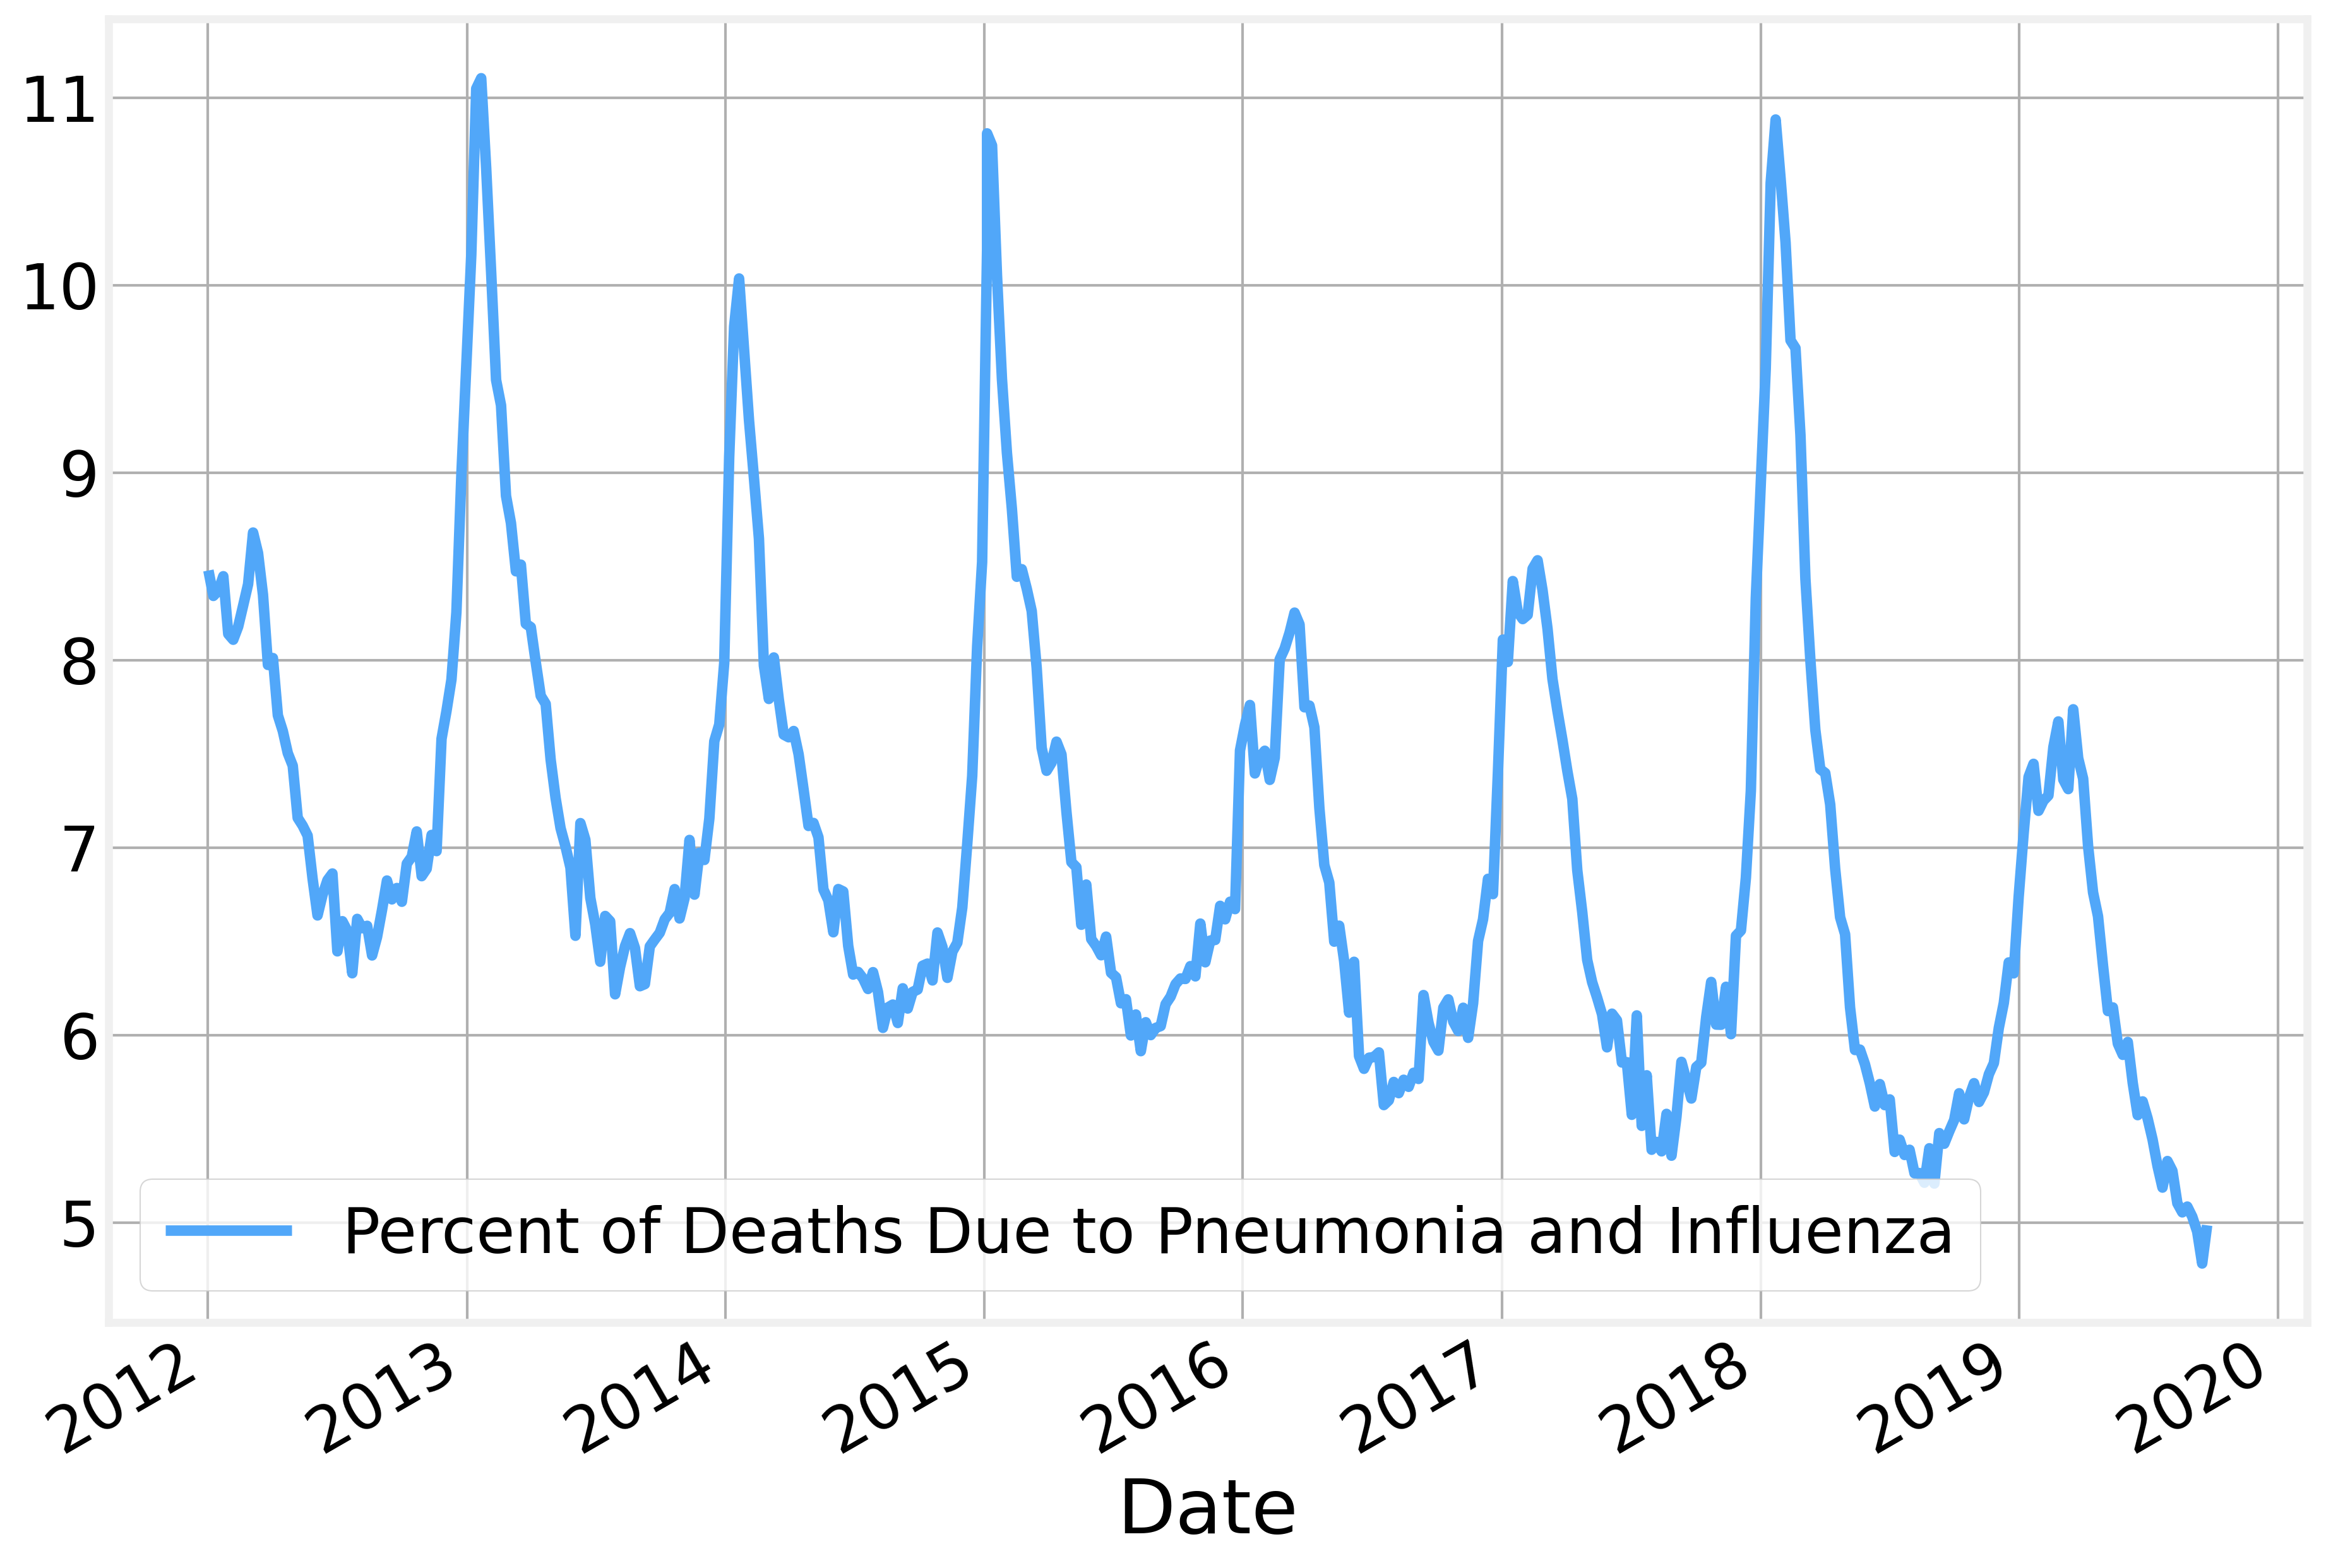

In [8]:
ILI.plot()

We start by performing an Augmented Dickey-Fuller test to confirm that the time series is stationary

In [9]:
adf, pvalue, critical, results = sm.tsa.stattools.adfuller(ILI, regresults=True)

which indeed is confirmed by the p-value

In [10]:
pvalue

0.00016034951684142202

The next step is then to plot the Autocorrelation function

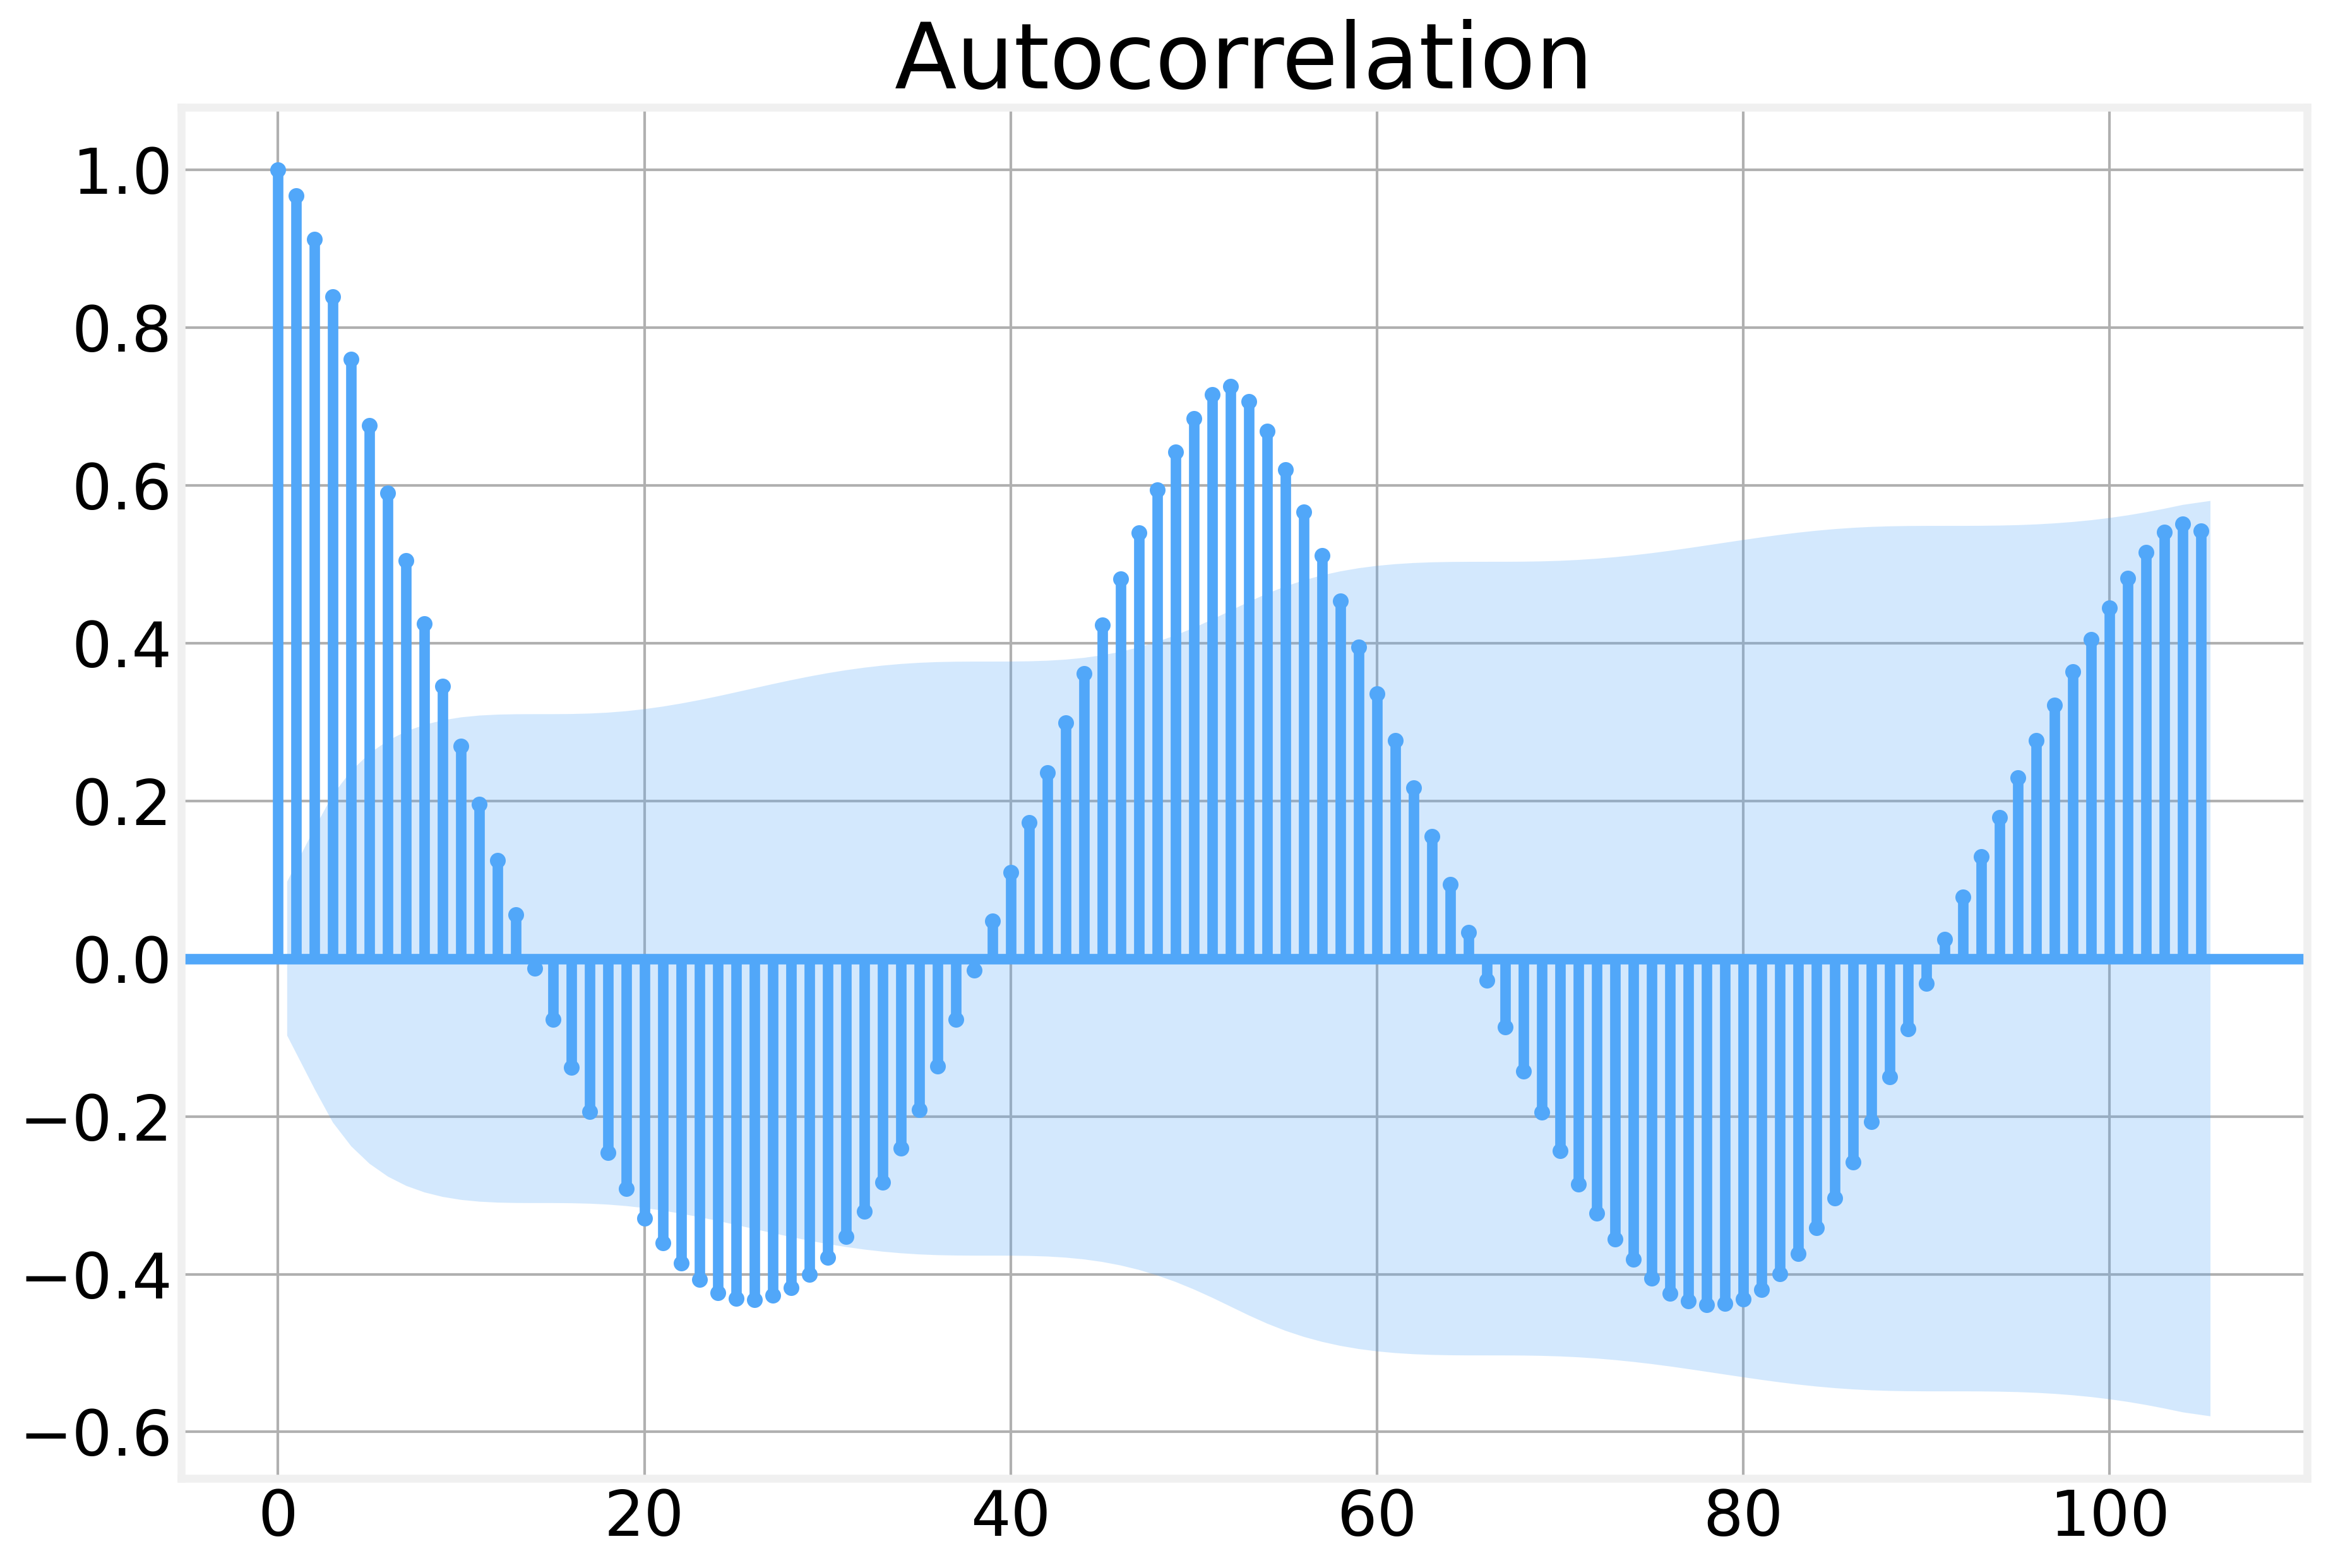

In [11]:
sm.graphics.tsa.plot_acf(ILI, lags=105);

This seems to indicate that the time series is not stationary. Indeed, the oscilating pattern of the ACF is a clue that the have a strong seasonal behavior every 52 weeks. We can (for now) bypass this problem by taking the first difference of the original timeseries

In [12]:
ILI2 = ILI.diff(1).dropna()[:'2018']

In [13]:
ILI2.tail()

,Percent of Deaths Due to Pneumonia and Influenza
Date,
2018-12-03,0.187939
2018-12-10,0.132627
2018-12-17,0.216503
2018-12-24,-0.058391
2018-12-31,0.408337


Let us visualize the difference dataset

Text(0, 0.5, 'WoW change')

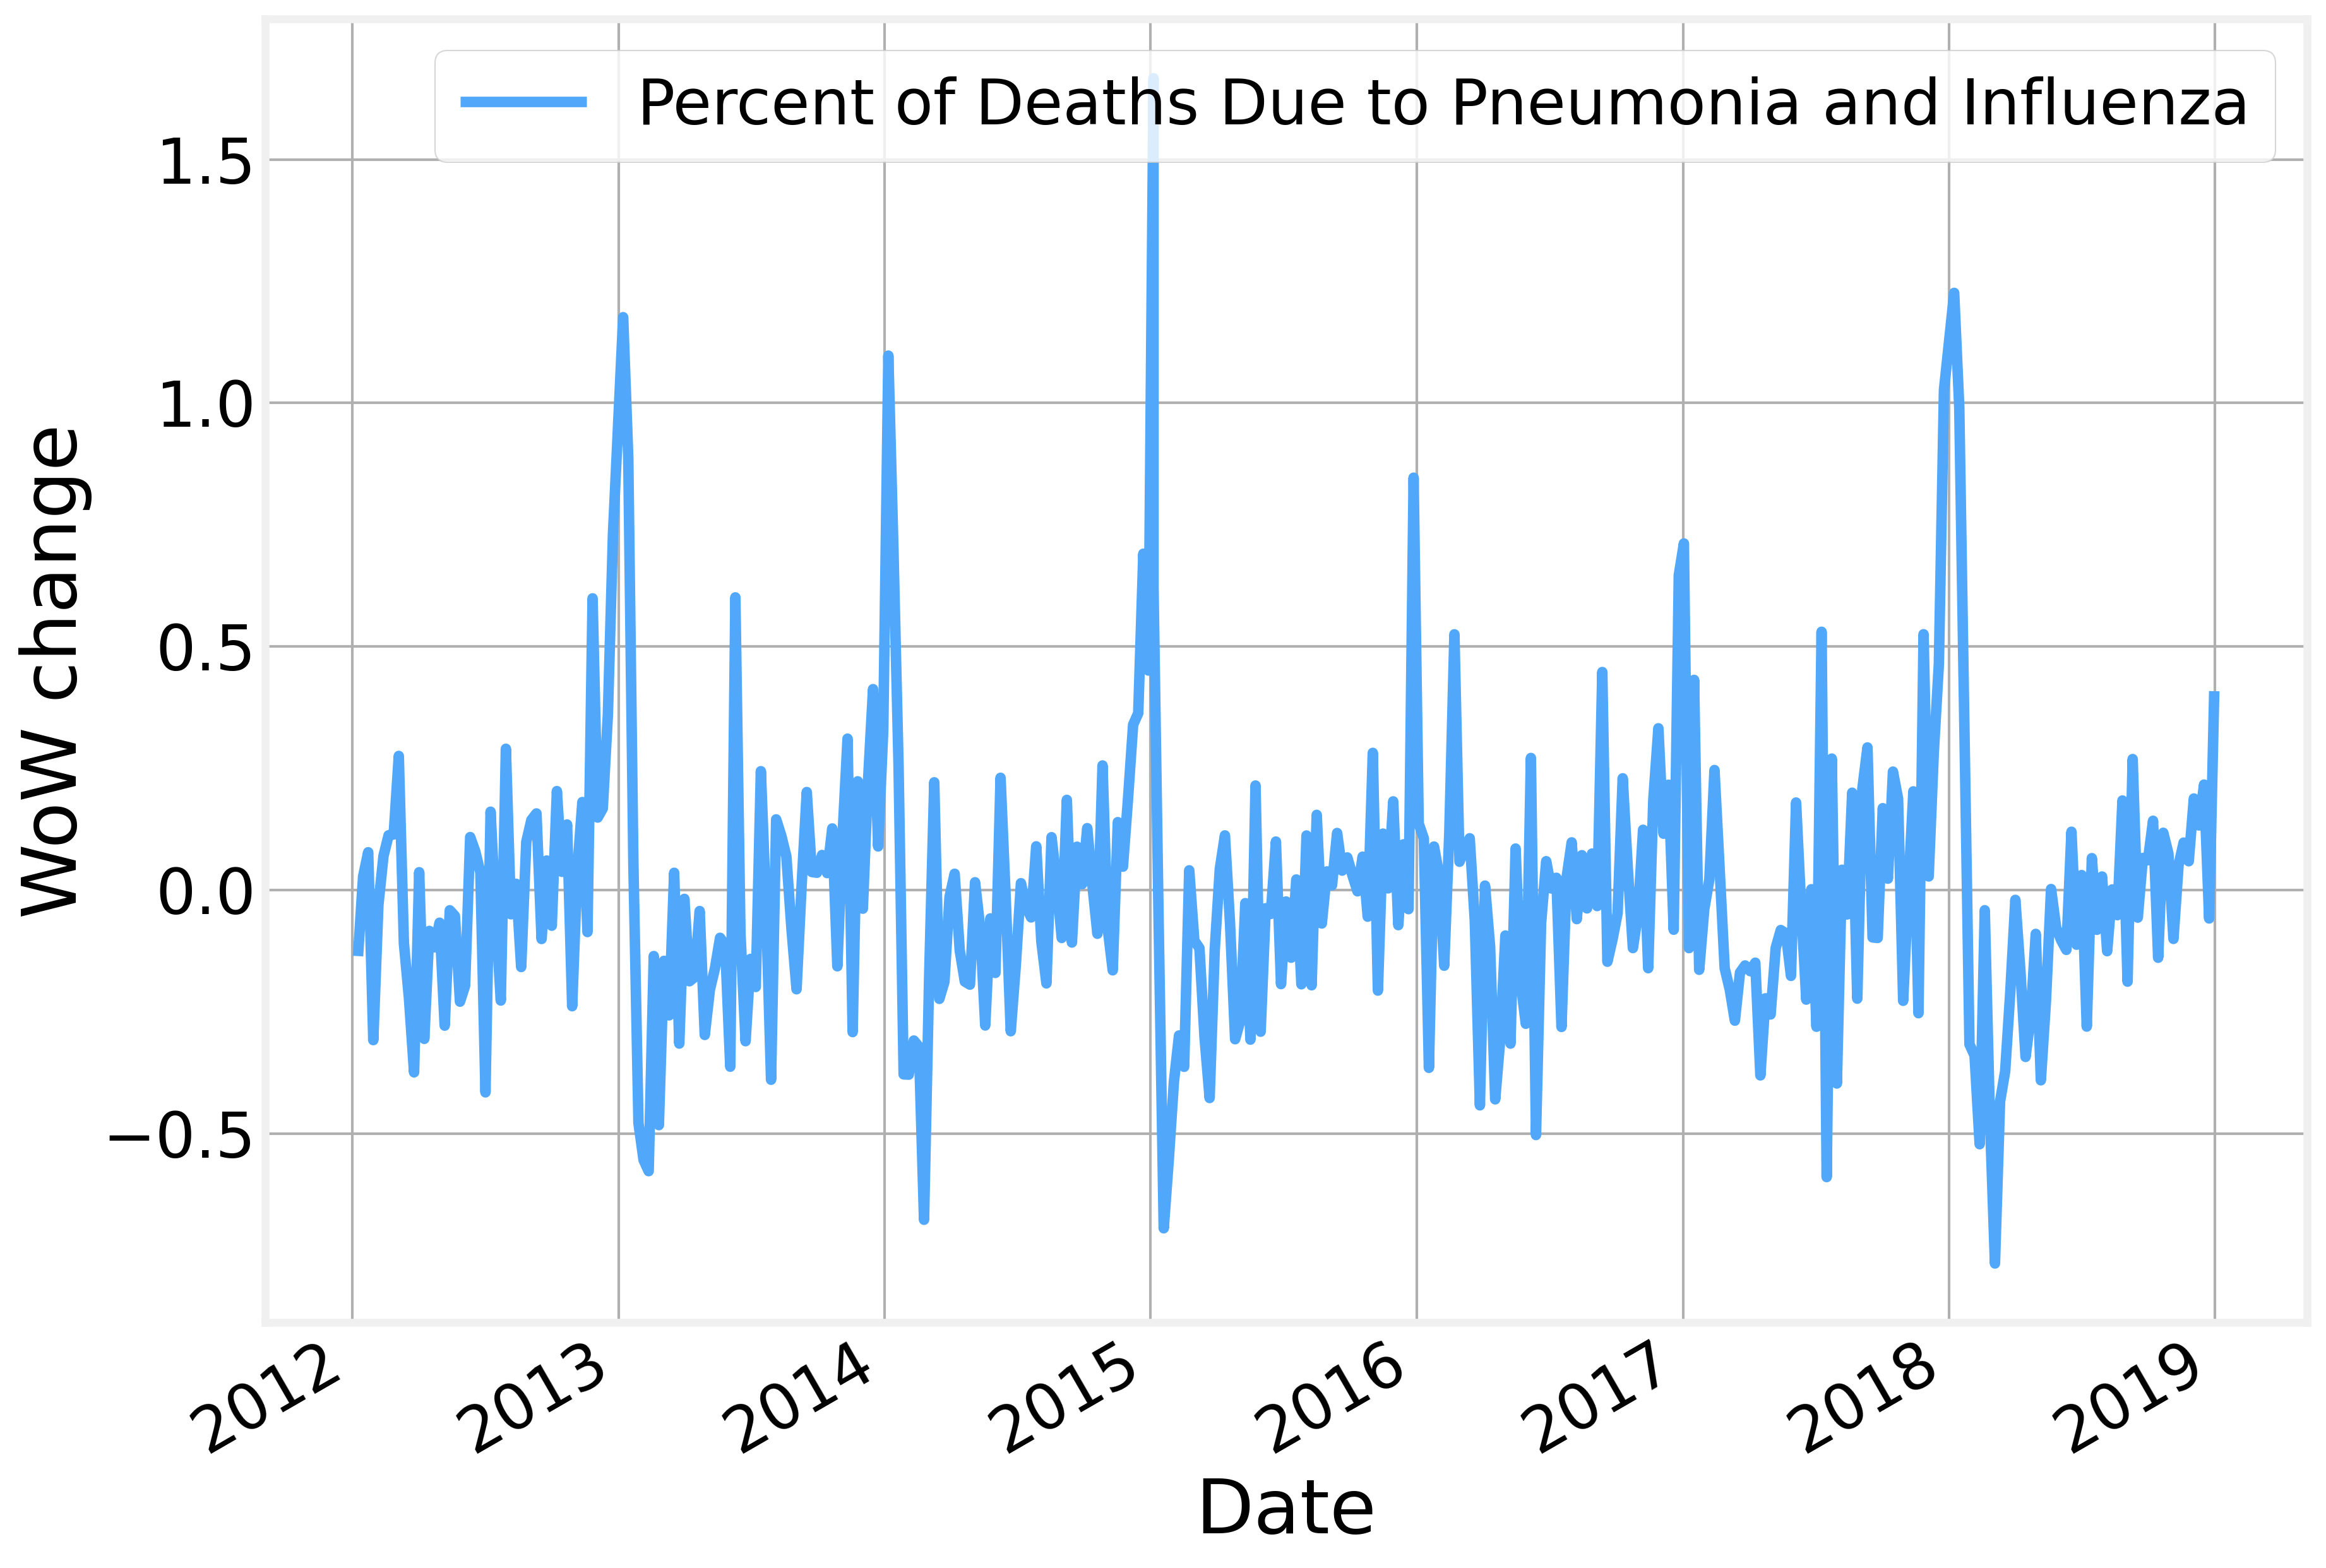

In [14]:
ax = ILI2.plot()
ax.set_ylabel('WoW change')

Now, when we plot the auto-correlation function we find something much more reasonable, with significant lags up to 2

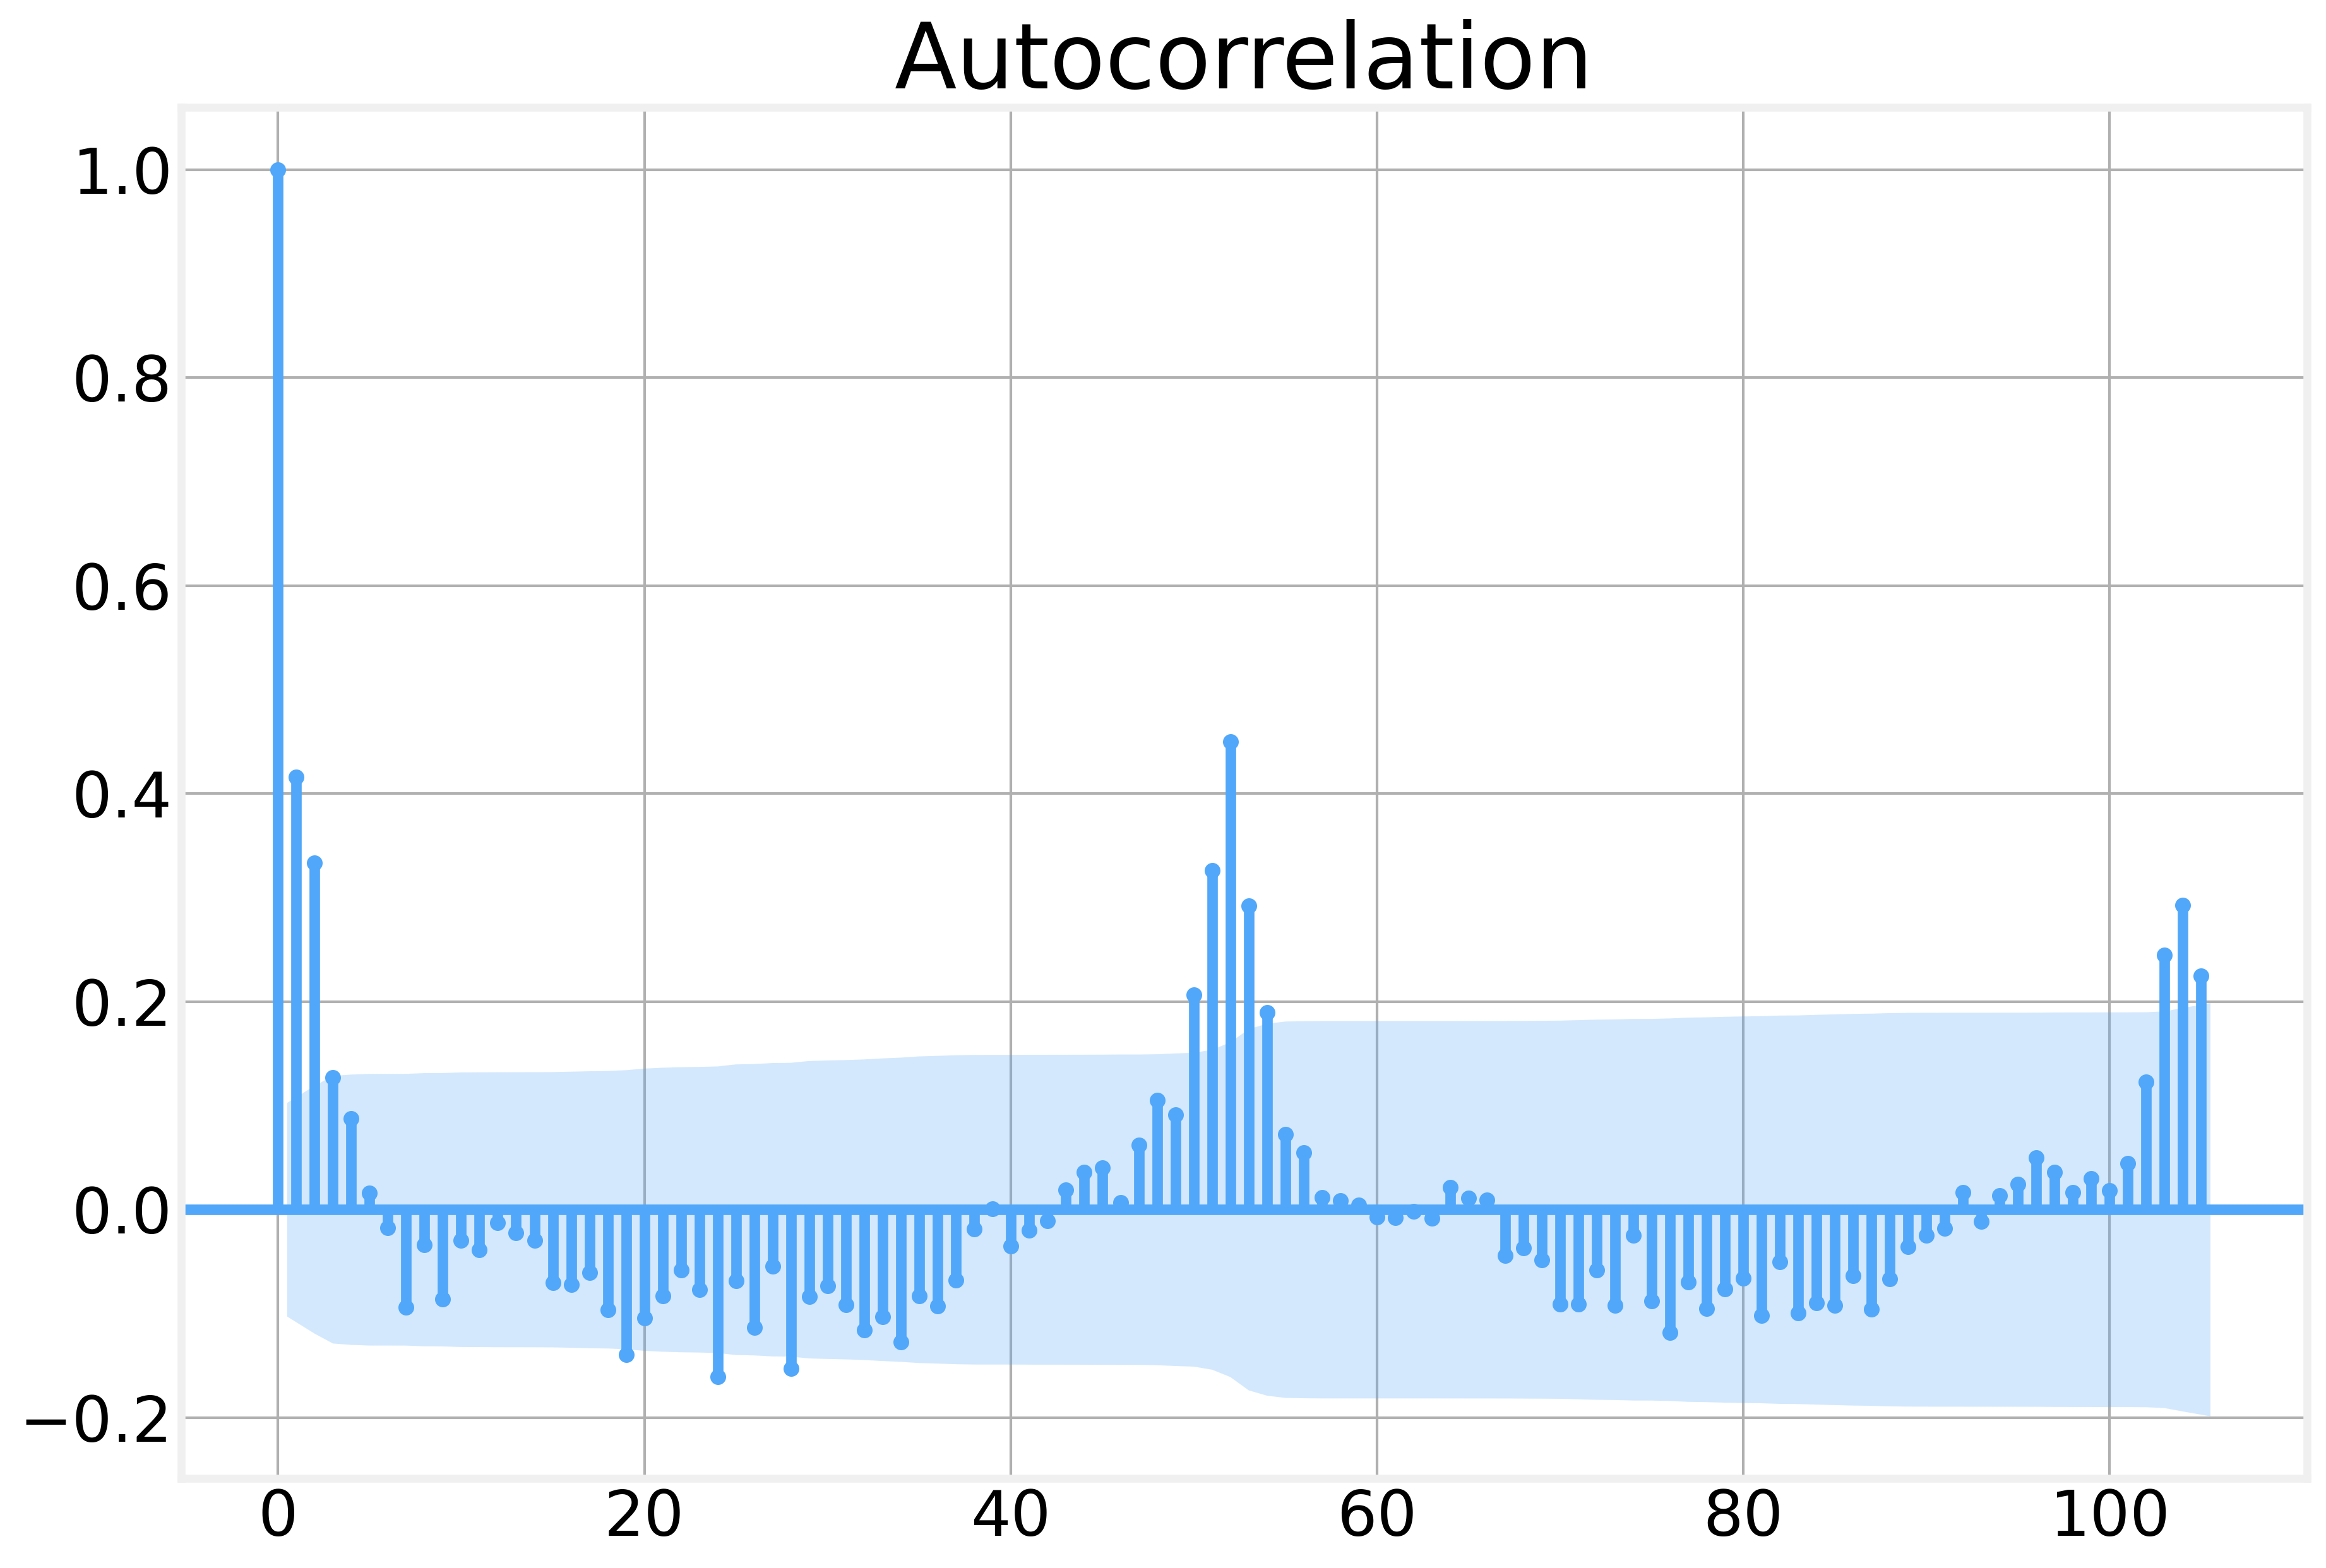

In [15]:
sm.graphics.tsa.plot_acf(ILI2, lags=105);

Although we haven't completely removed the seasonal behavior it is much reduced.

Next we plot the PACF

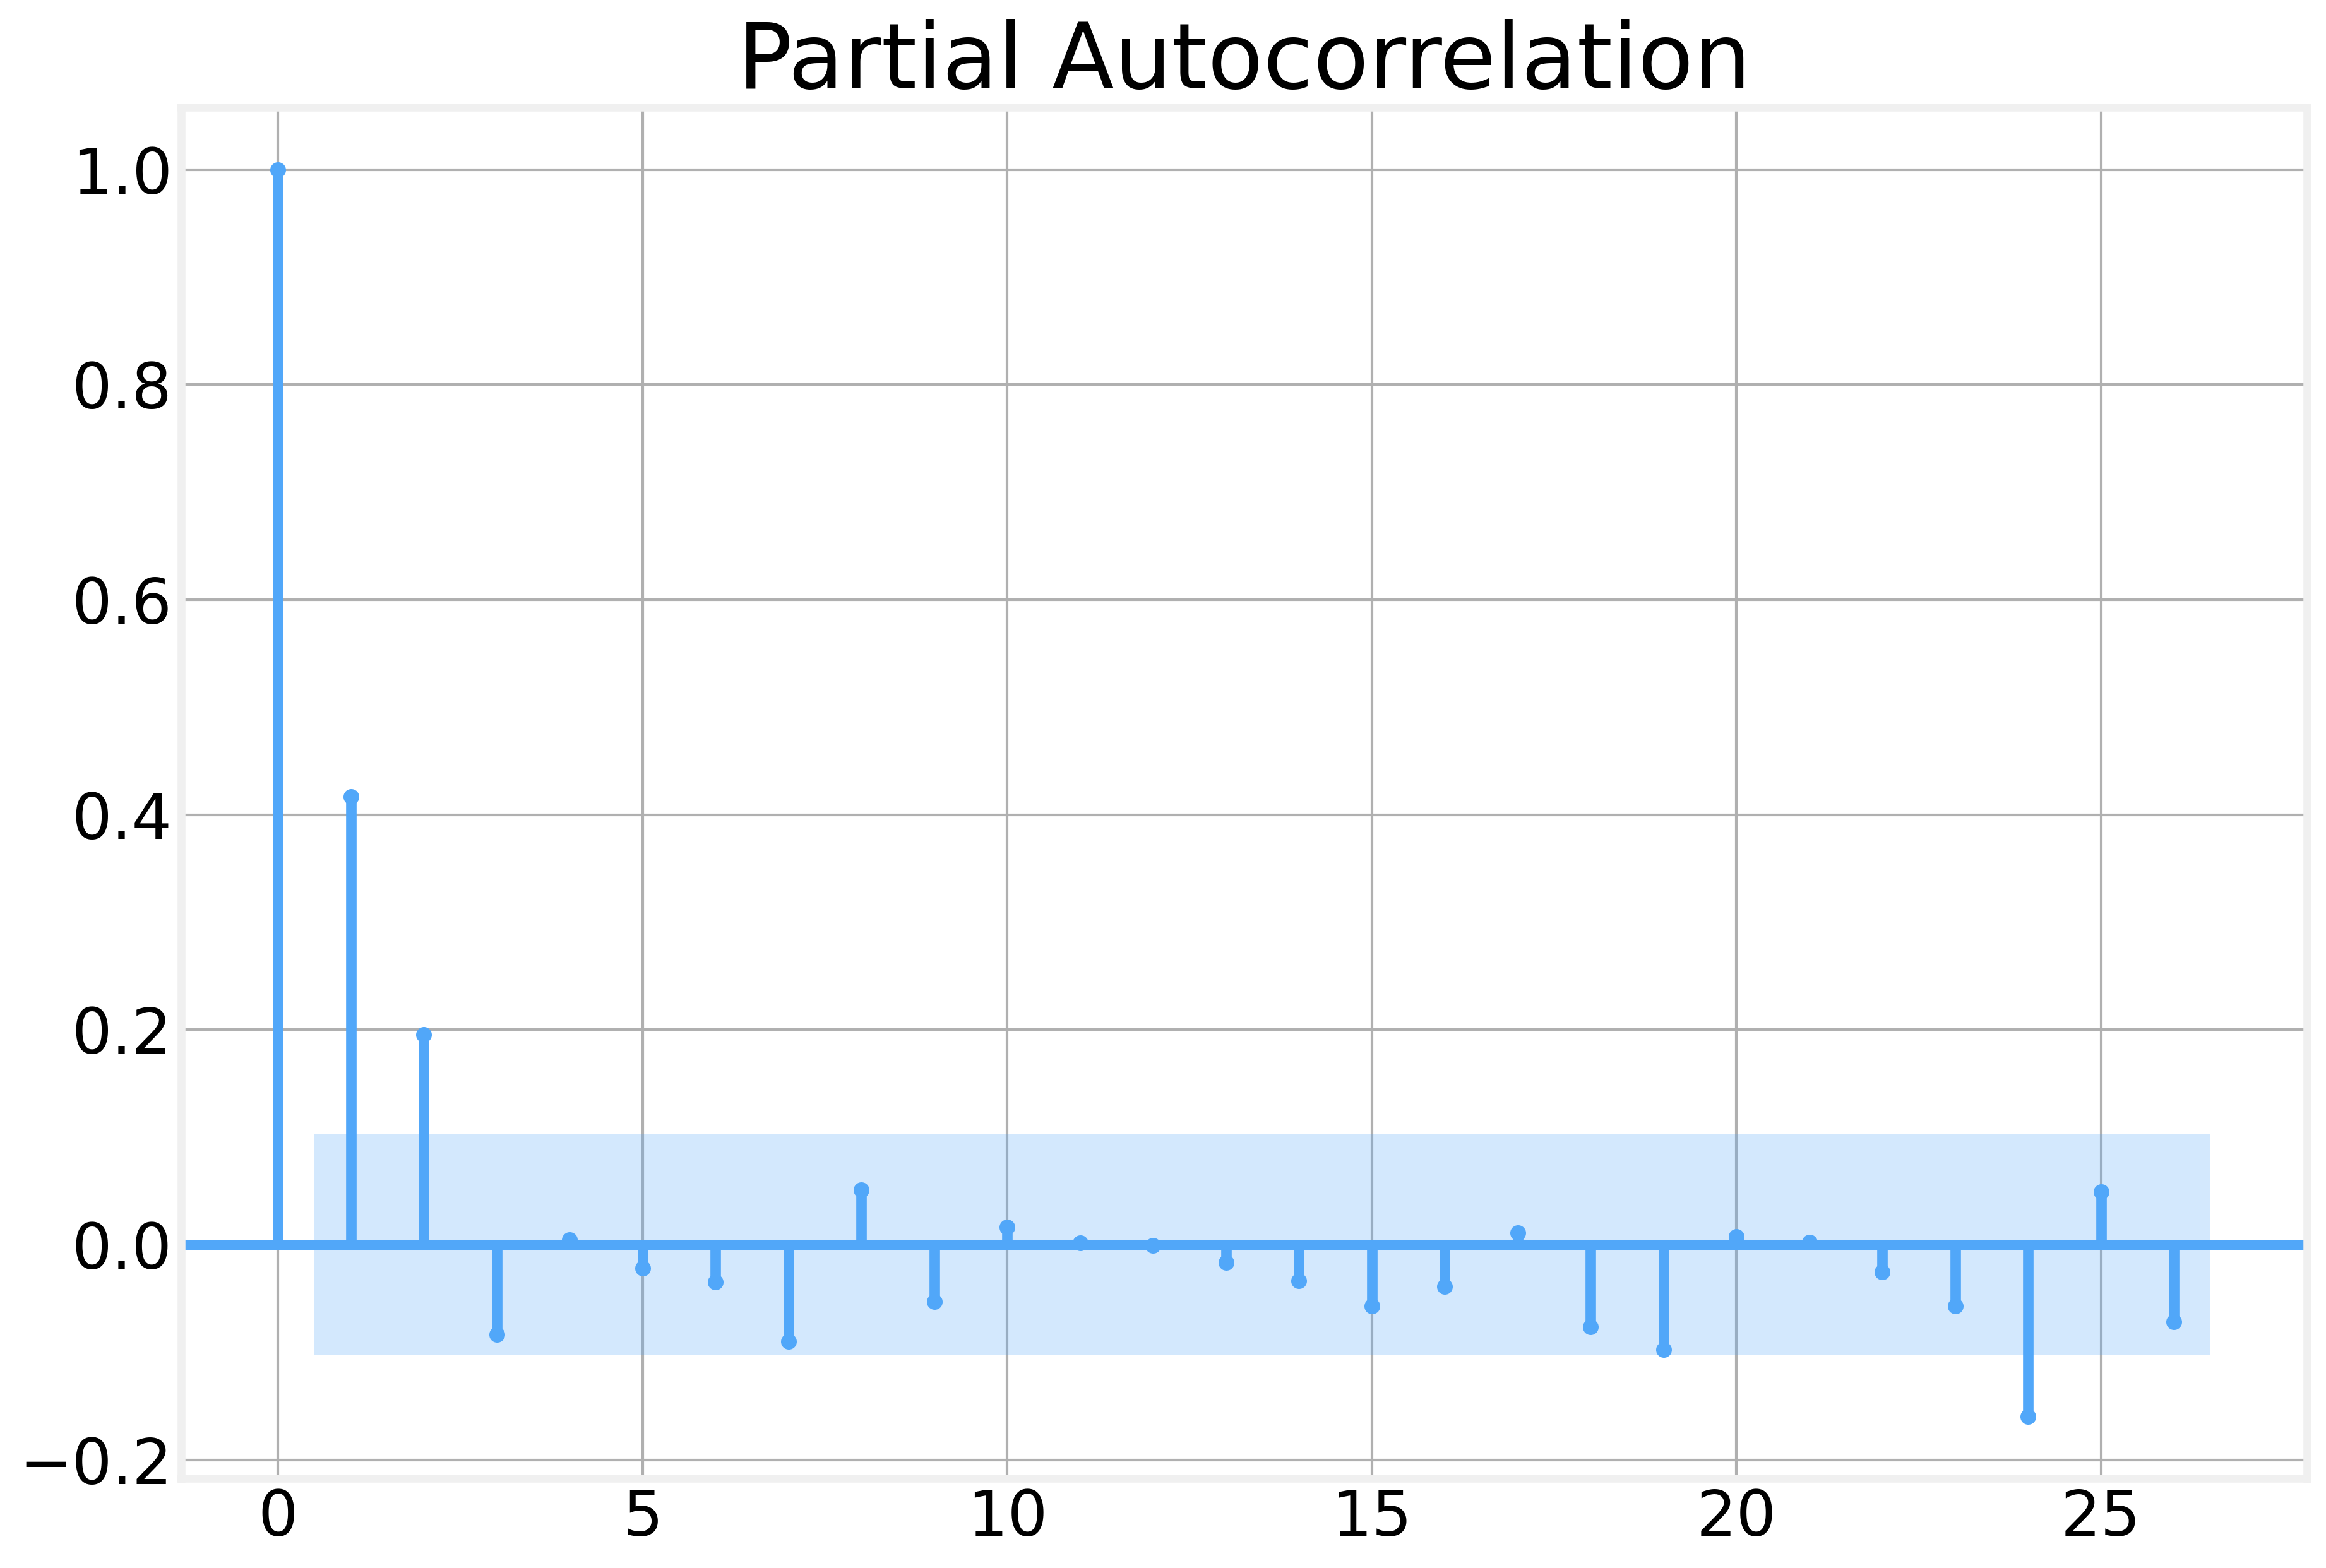

In [16]:
sm.graphics.tsa.plot_pacf(ILI2);

And again find two significant lags

In [17]:
model = sm.tsa.ARIMA(ILI[:'2018'], (2, 1, 2))
results = model.fit()

In [18]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                             ARIMA Model Results                                              
==============================================================================================================
Dep. Variable:     D.Percent of Deaths Due to Pneumonia and Influenza   No. Observations:                  364
Model:                                                 ARIMA(2, 1, 2)   Log Likelihood                 -25.016
Method:                                                       css-mle   S.D. of innovations              0.259
Date:                                                Fri, 15 Oct 2021   AIC                             62.032
Time:                                                        10:50:17   BIC                             85.415
Sample:                                                             1   HQIC                            71.325
                                                                                                              
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                       -0.0042      0.027     -0.154      0.877      -0.057       0.049
ar.L1.D.Percent of Deaths Due to Pneumonia and Influenza     0.0477      0.370      0.129      0.897      -0.678       0.773
ar.L2.D.Percent of Deaths Due to Pneumonia and Influenza     0.2714      0.316      0.859      0.390      -0.348       0.891
ma.L1.D.Percent of Deaths Due to Pneumonia and Influenza     0.3046      0.373      0.817      0.414      -0.426       1.035
ma.L2.D.Percent of Deaths Due to Pneumonia and Influenza     0.0540      0.219      0.246      0.805      -0.376       0.484
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8336           +0.0000j            1.8336            0.0000
AR.2           -2.0094           +0.0000j            2.0094            0.5000
MA.1           -2.8200           -3.2501j            4.3030           -0.3637
MA.2           -2.8200           +3.2501j            4.3030            0.3637
-----------------------------------------------------------------------------
"""

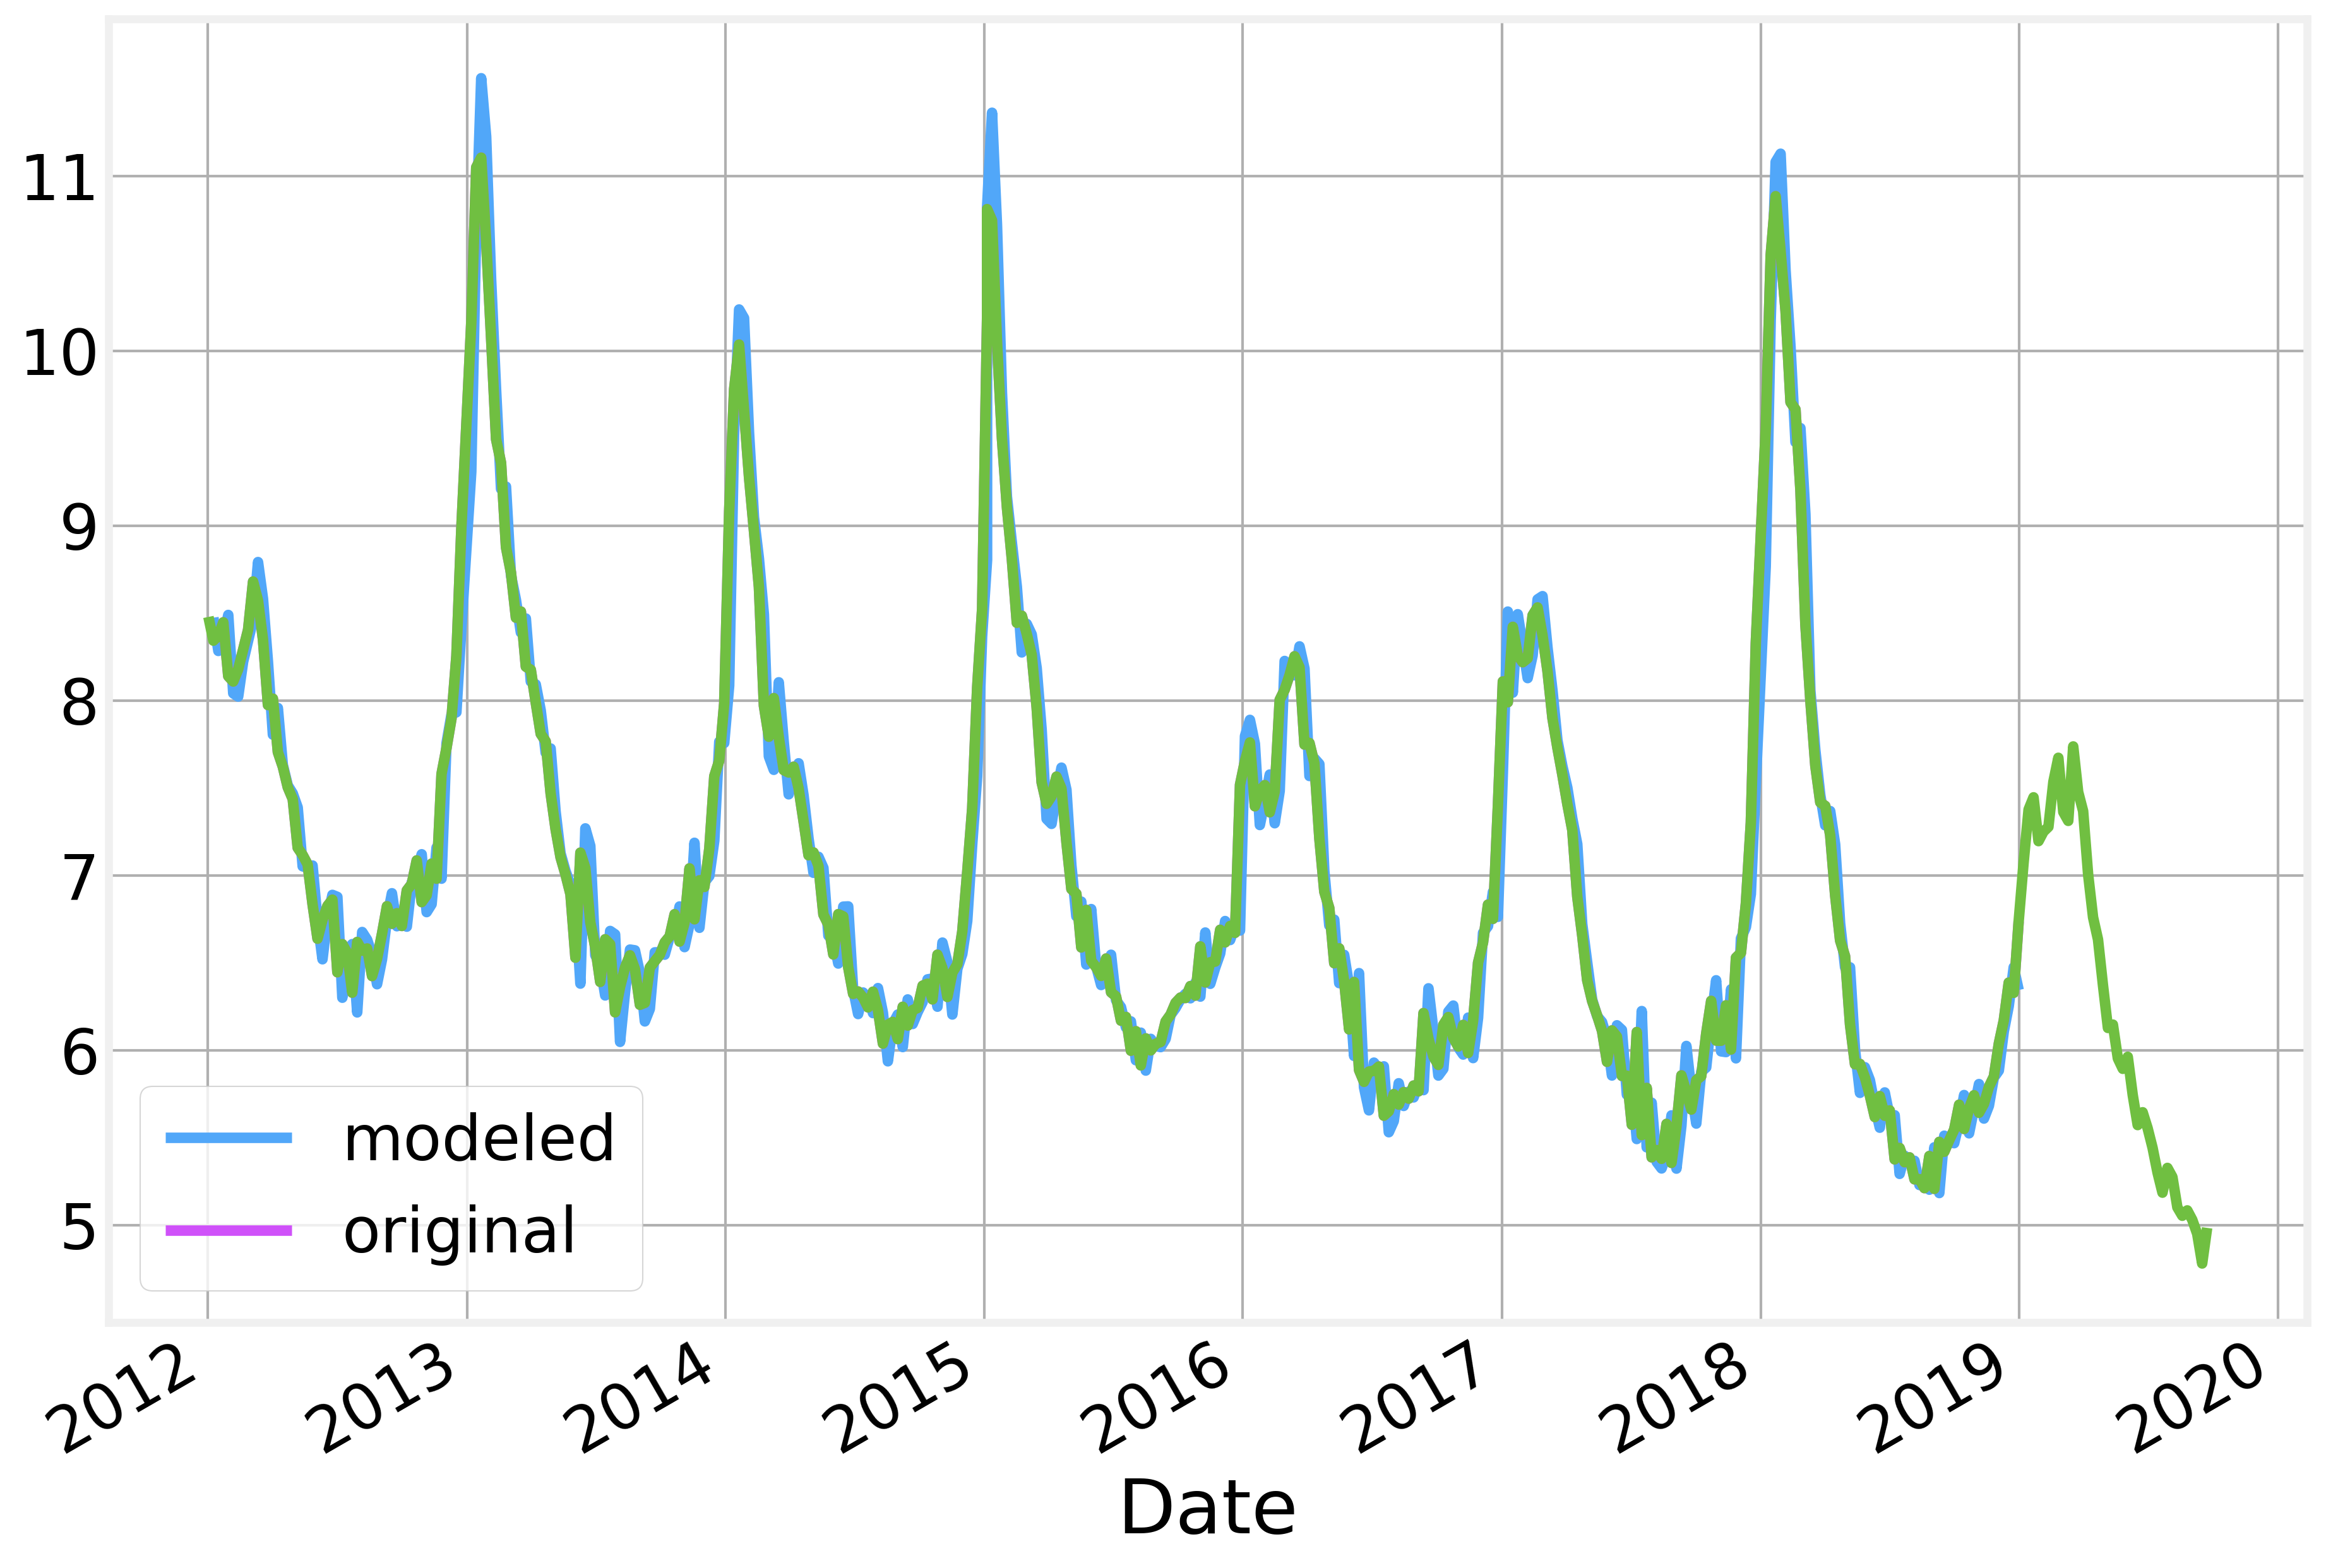

In [19]:
fig, ax = plt.subplots(1, 1)
pred_sm = results.plot_predict(ax=ax)
ILI.plot(ax=ax)
plt.legend(['modeled', 'original'])

(4.0, 12.0)

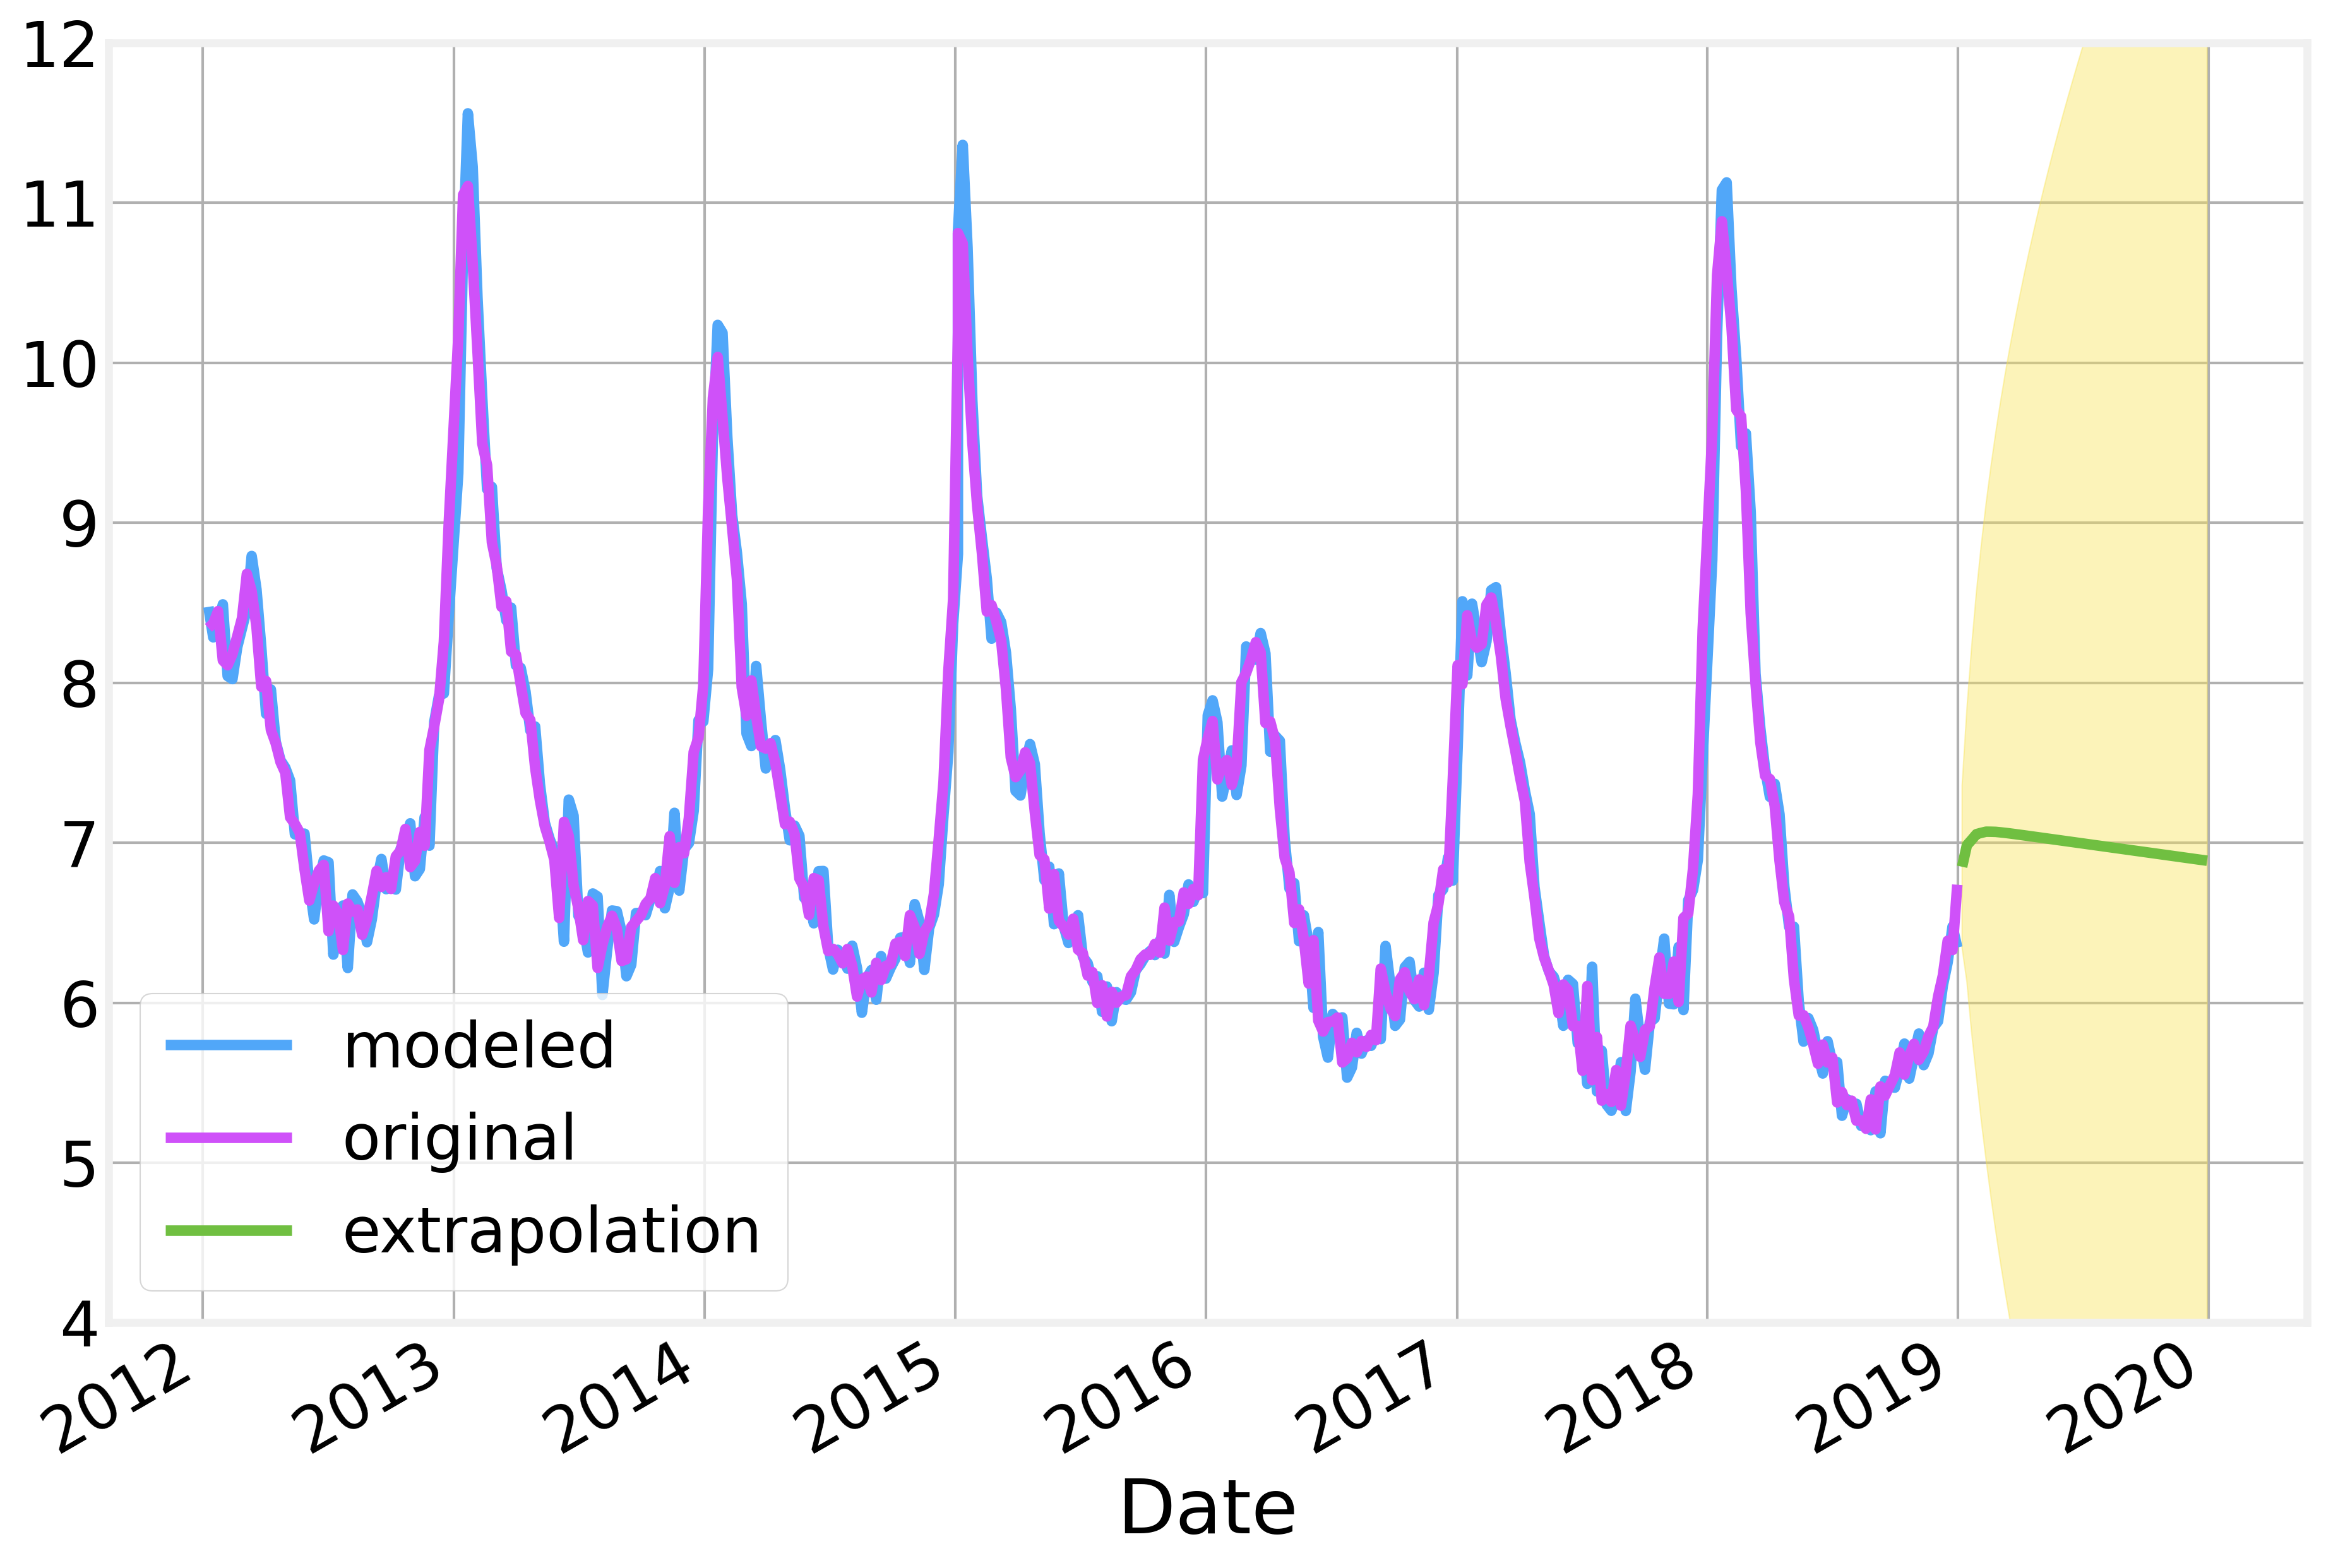

In [20]:
fig, ax = plt.subplots(1, 1)
results.plot_predict(ax=ax);

new_weeks = ILI2.index[-1]+pd.timedelta_range('7 day', periods=52, freq='7d')
forecast = results.forecast(steps=52)
ax.plot(new_weeks, forecast[0])
ax.fill_between(new_weeks, forecast[2].T[0], forecast[2].T[1], alpha=0.4, color=colors[4])

ax.legend(['modeled', 'original', 'extrapolation'])
ax.set_ylim(4, 12)

# SARIMA

In [21]:
seasonal_ILI = ILI.diff(52).diff(1).dropna().copy()

<AxesSubplot:xlabel='Date'>

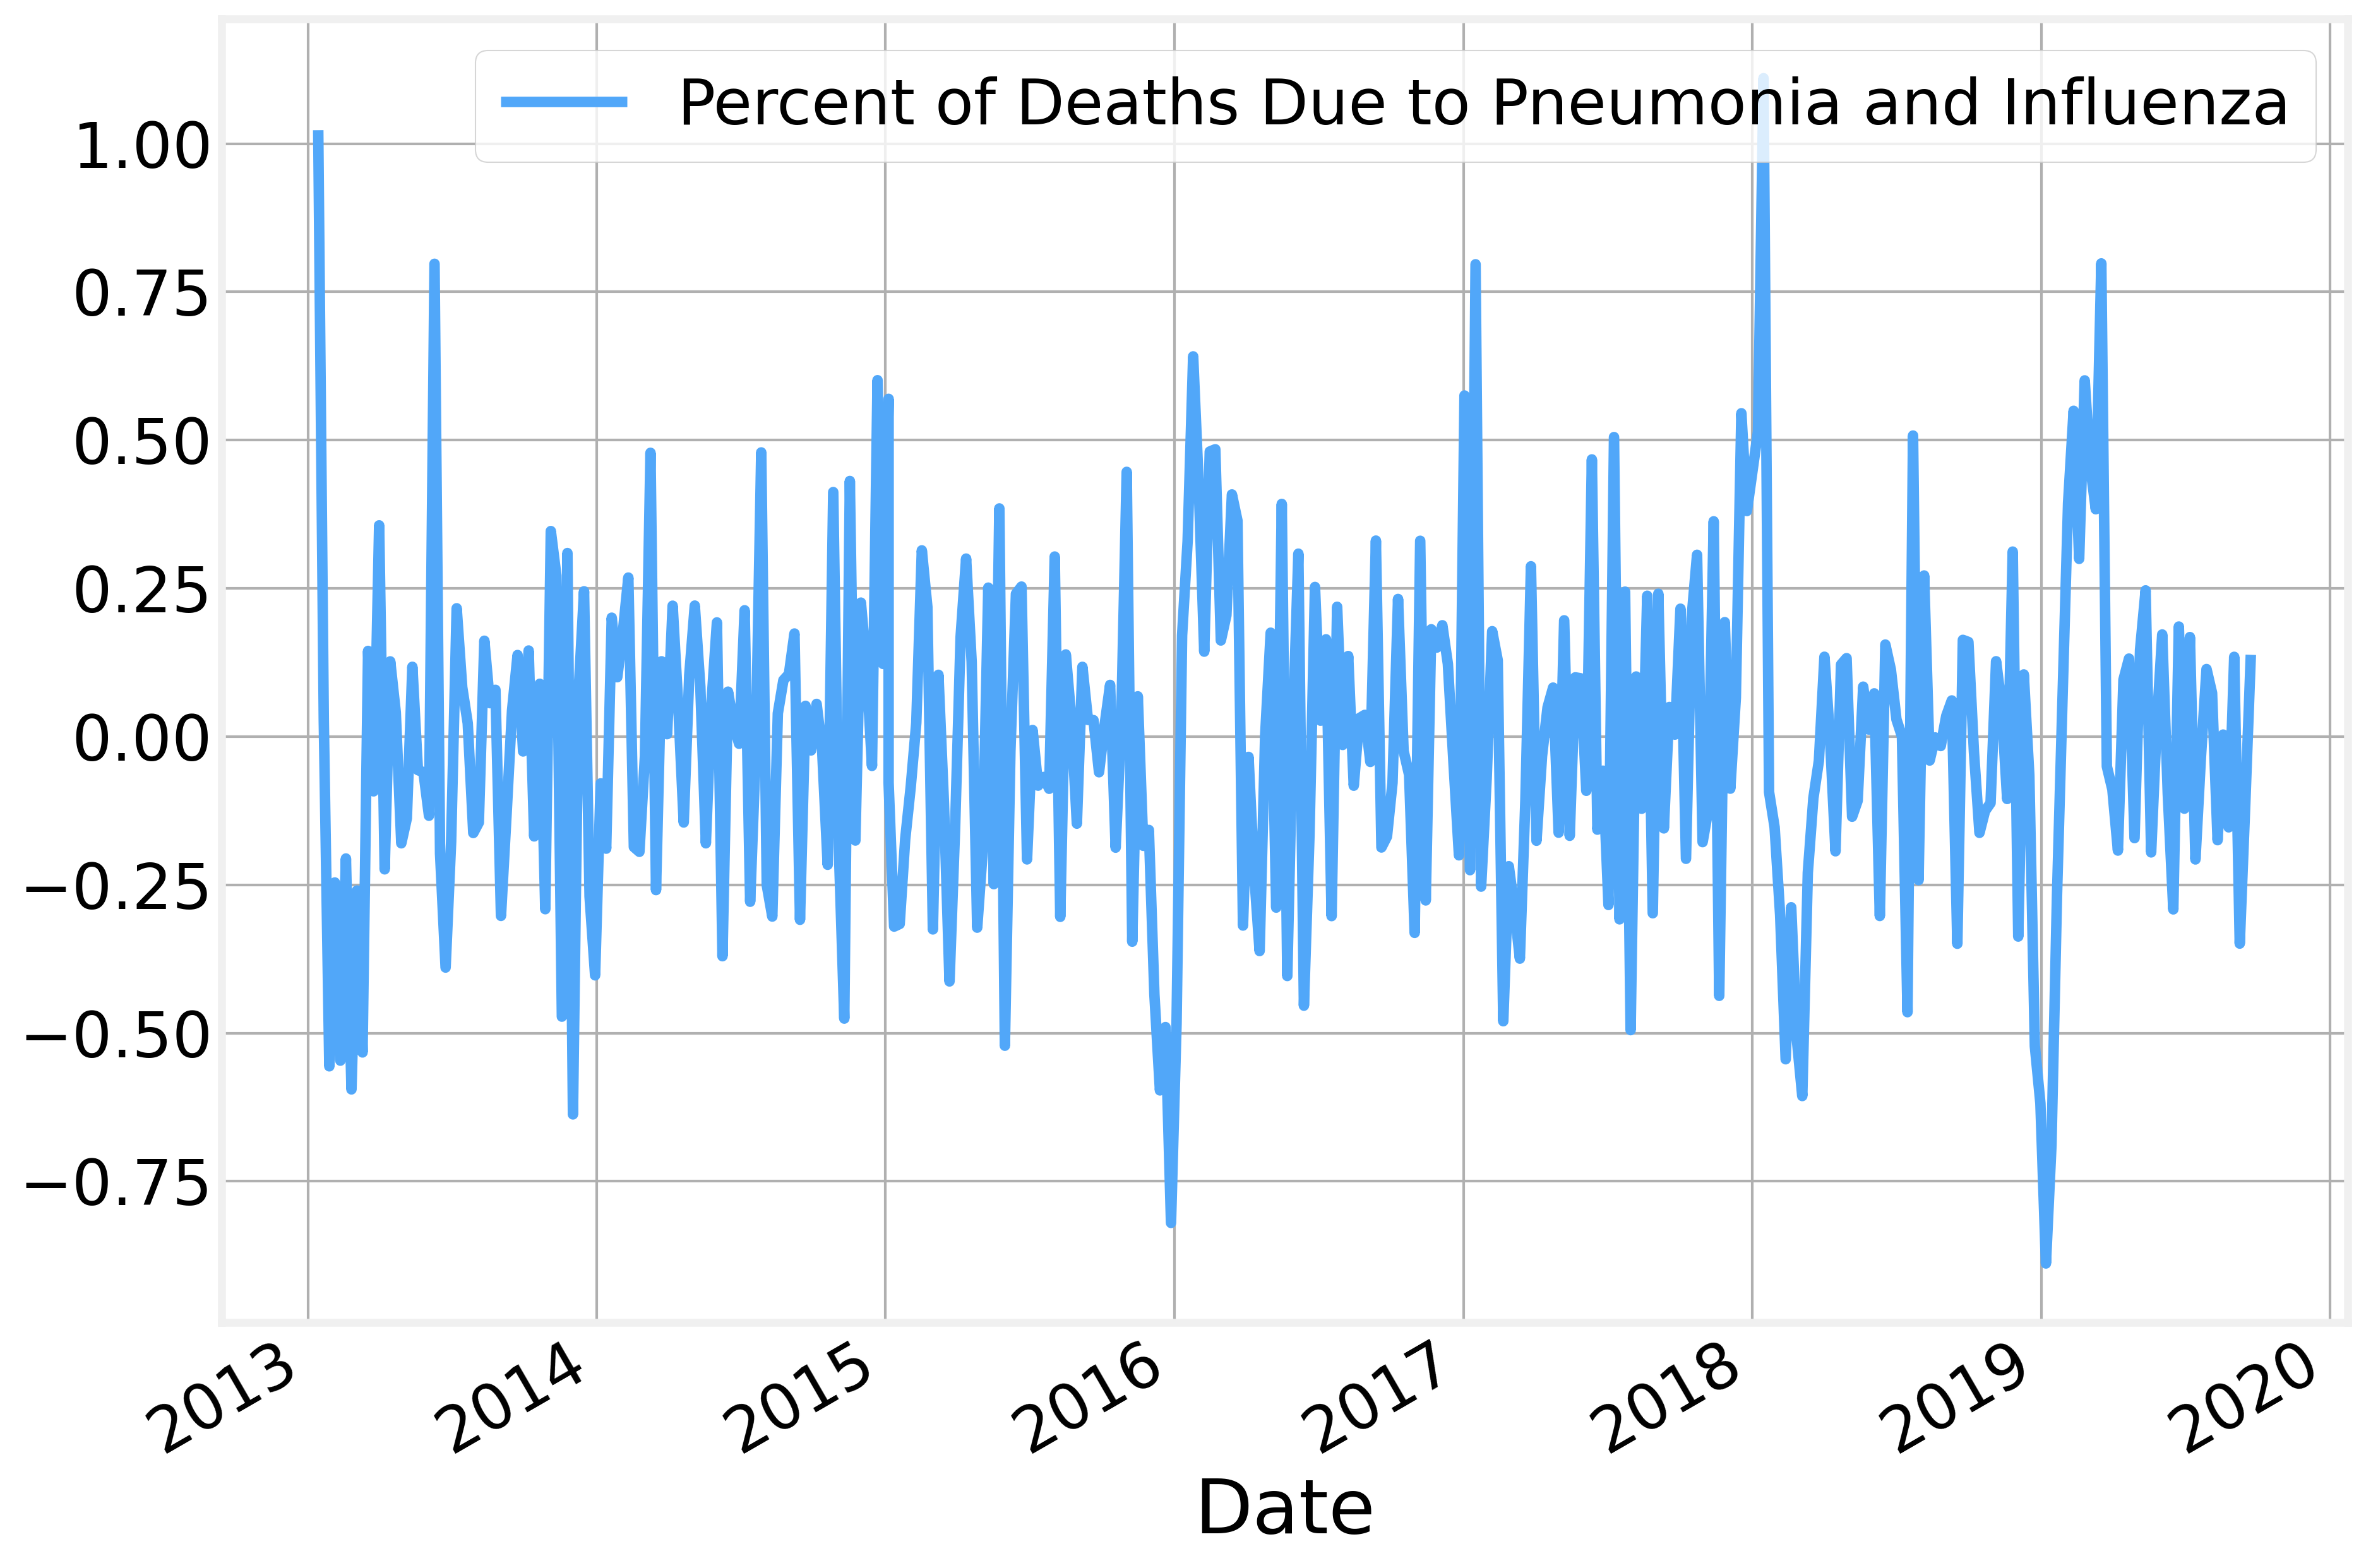

In [22]:
seasonal_ILI.plot()

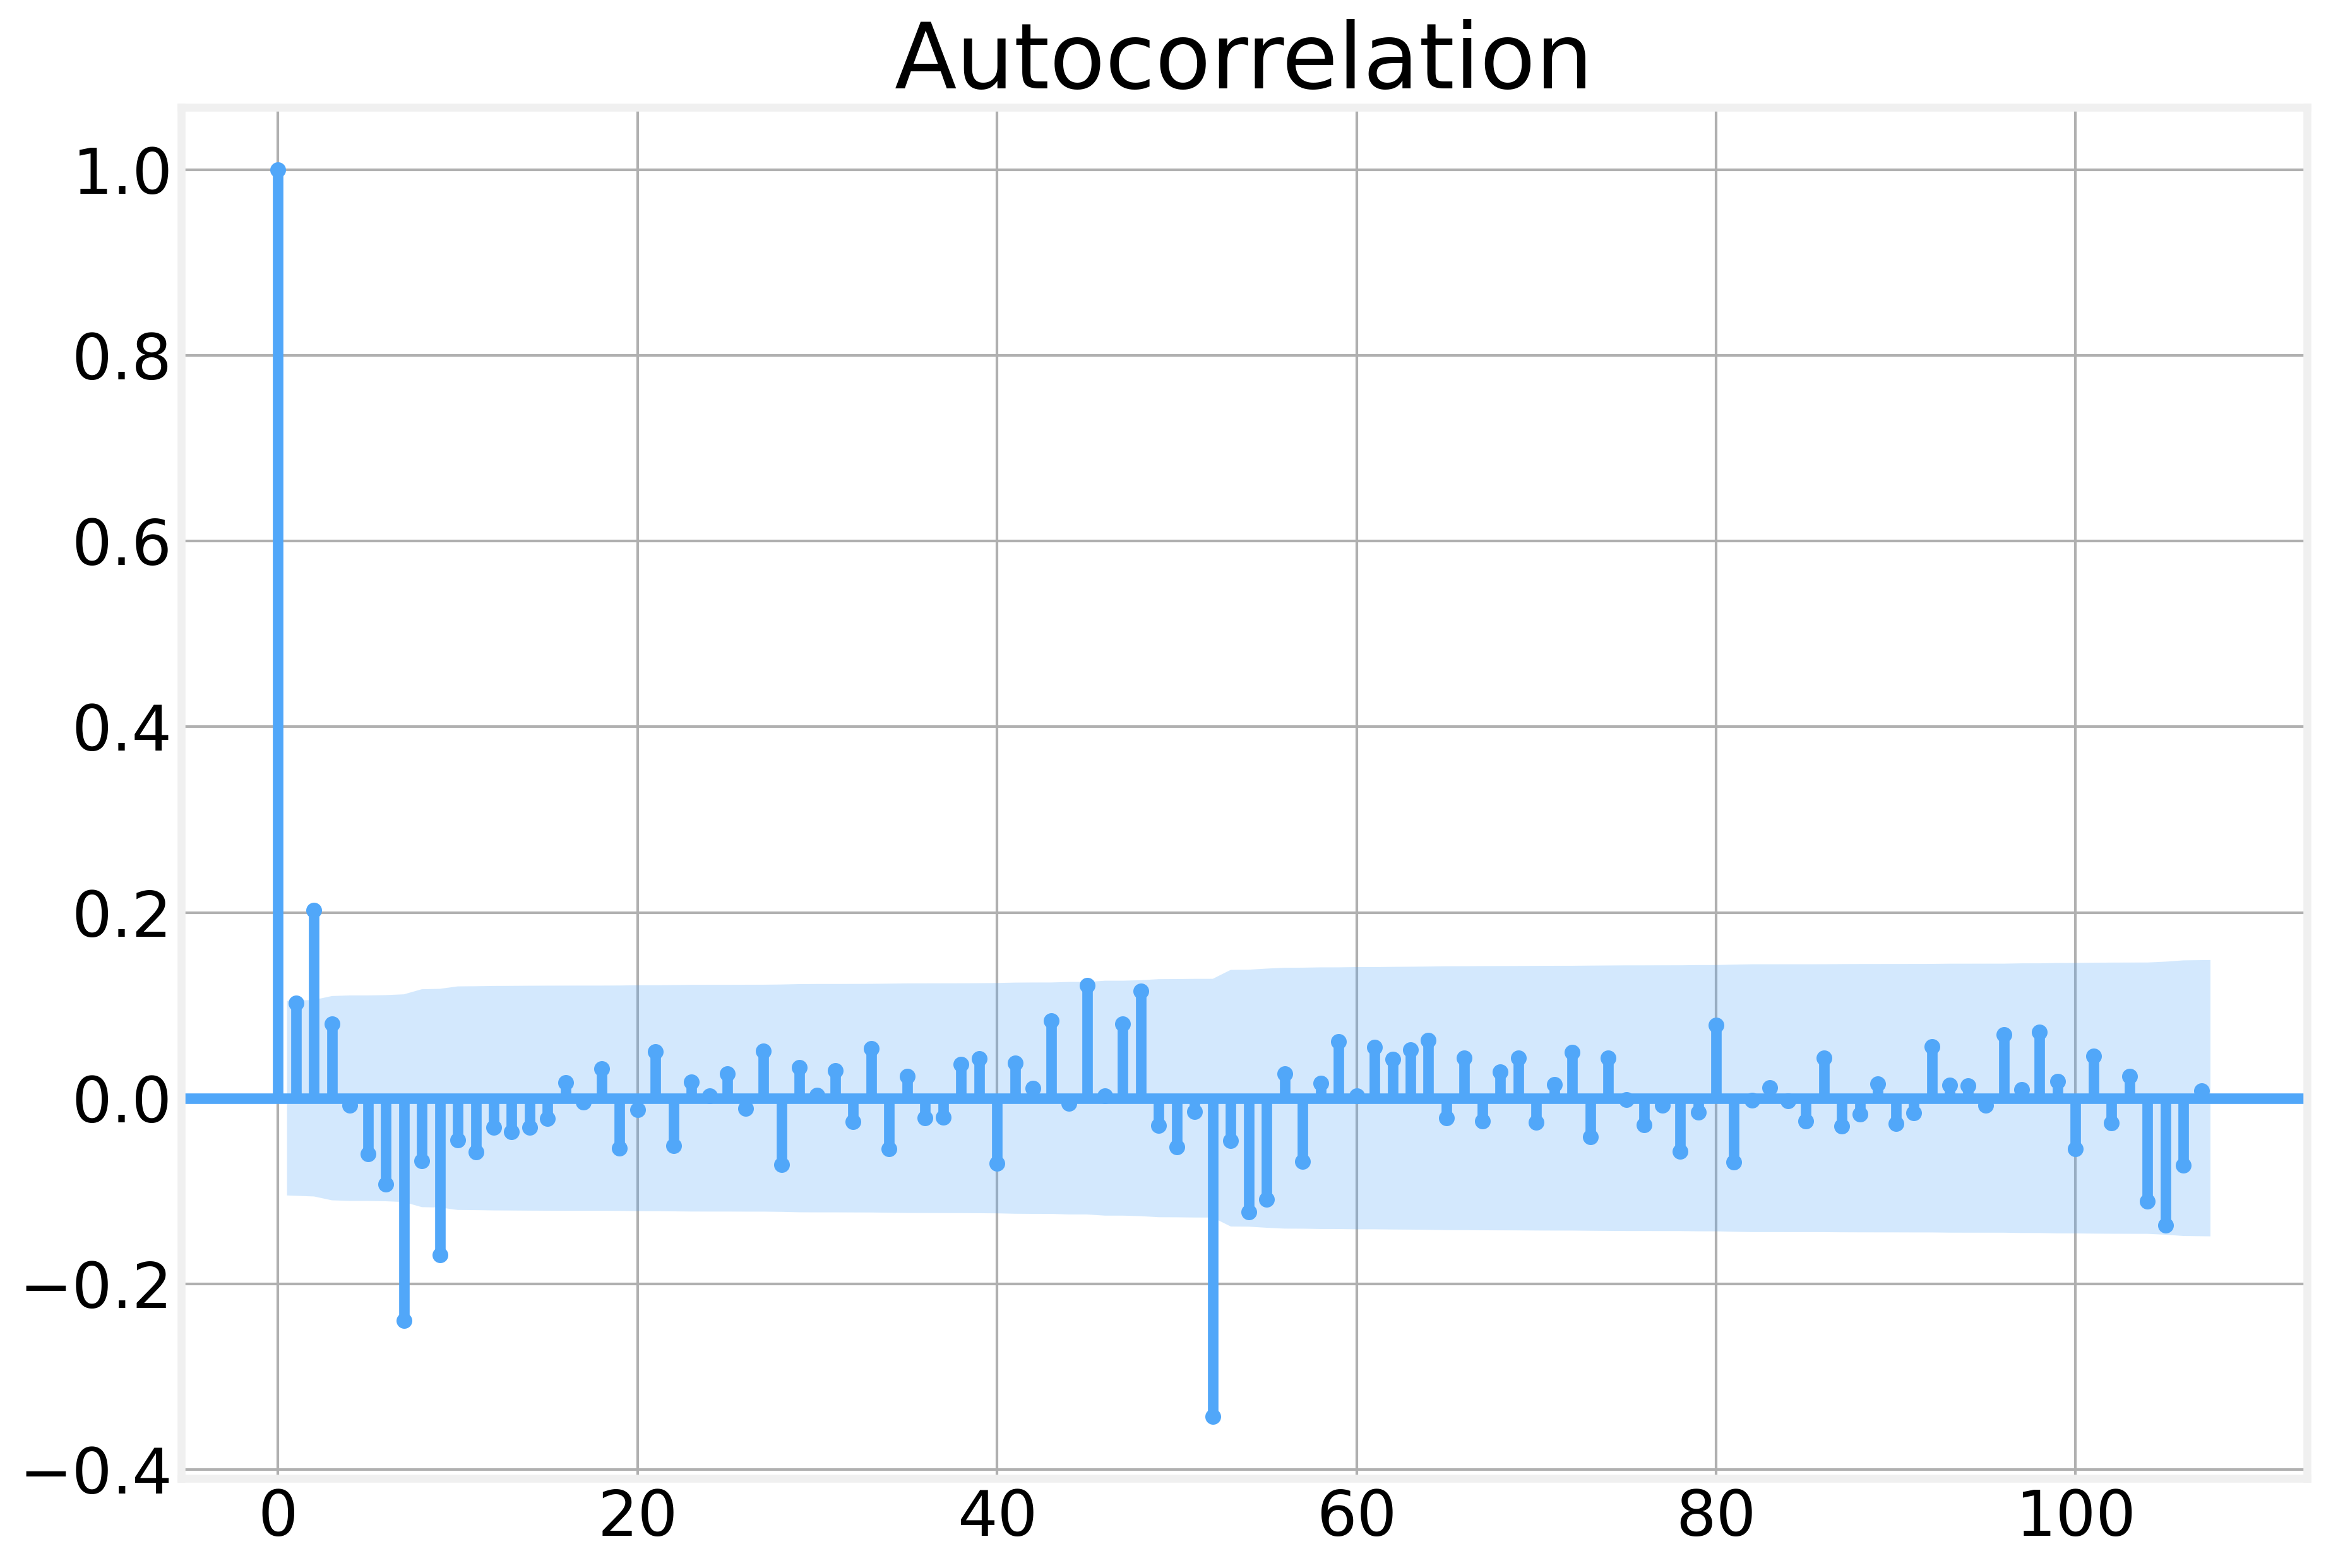

In [23]:
sm.graphics.tsa.plot_acf(seasonal_ILI, lags=107);

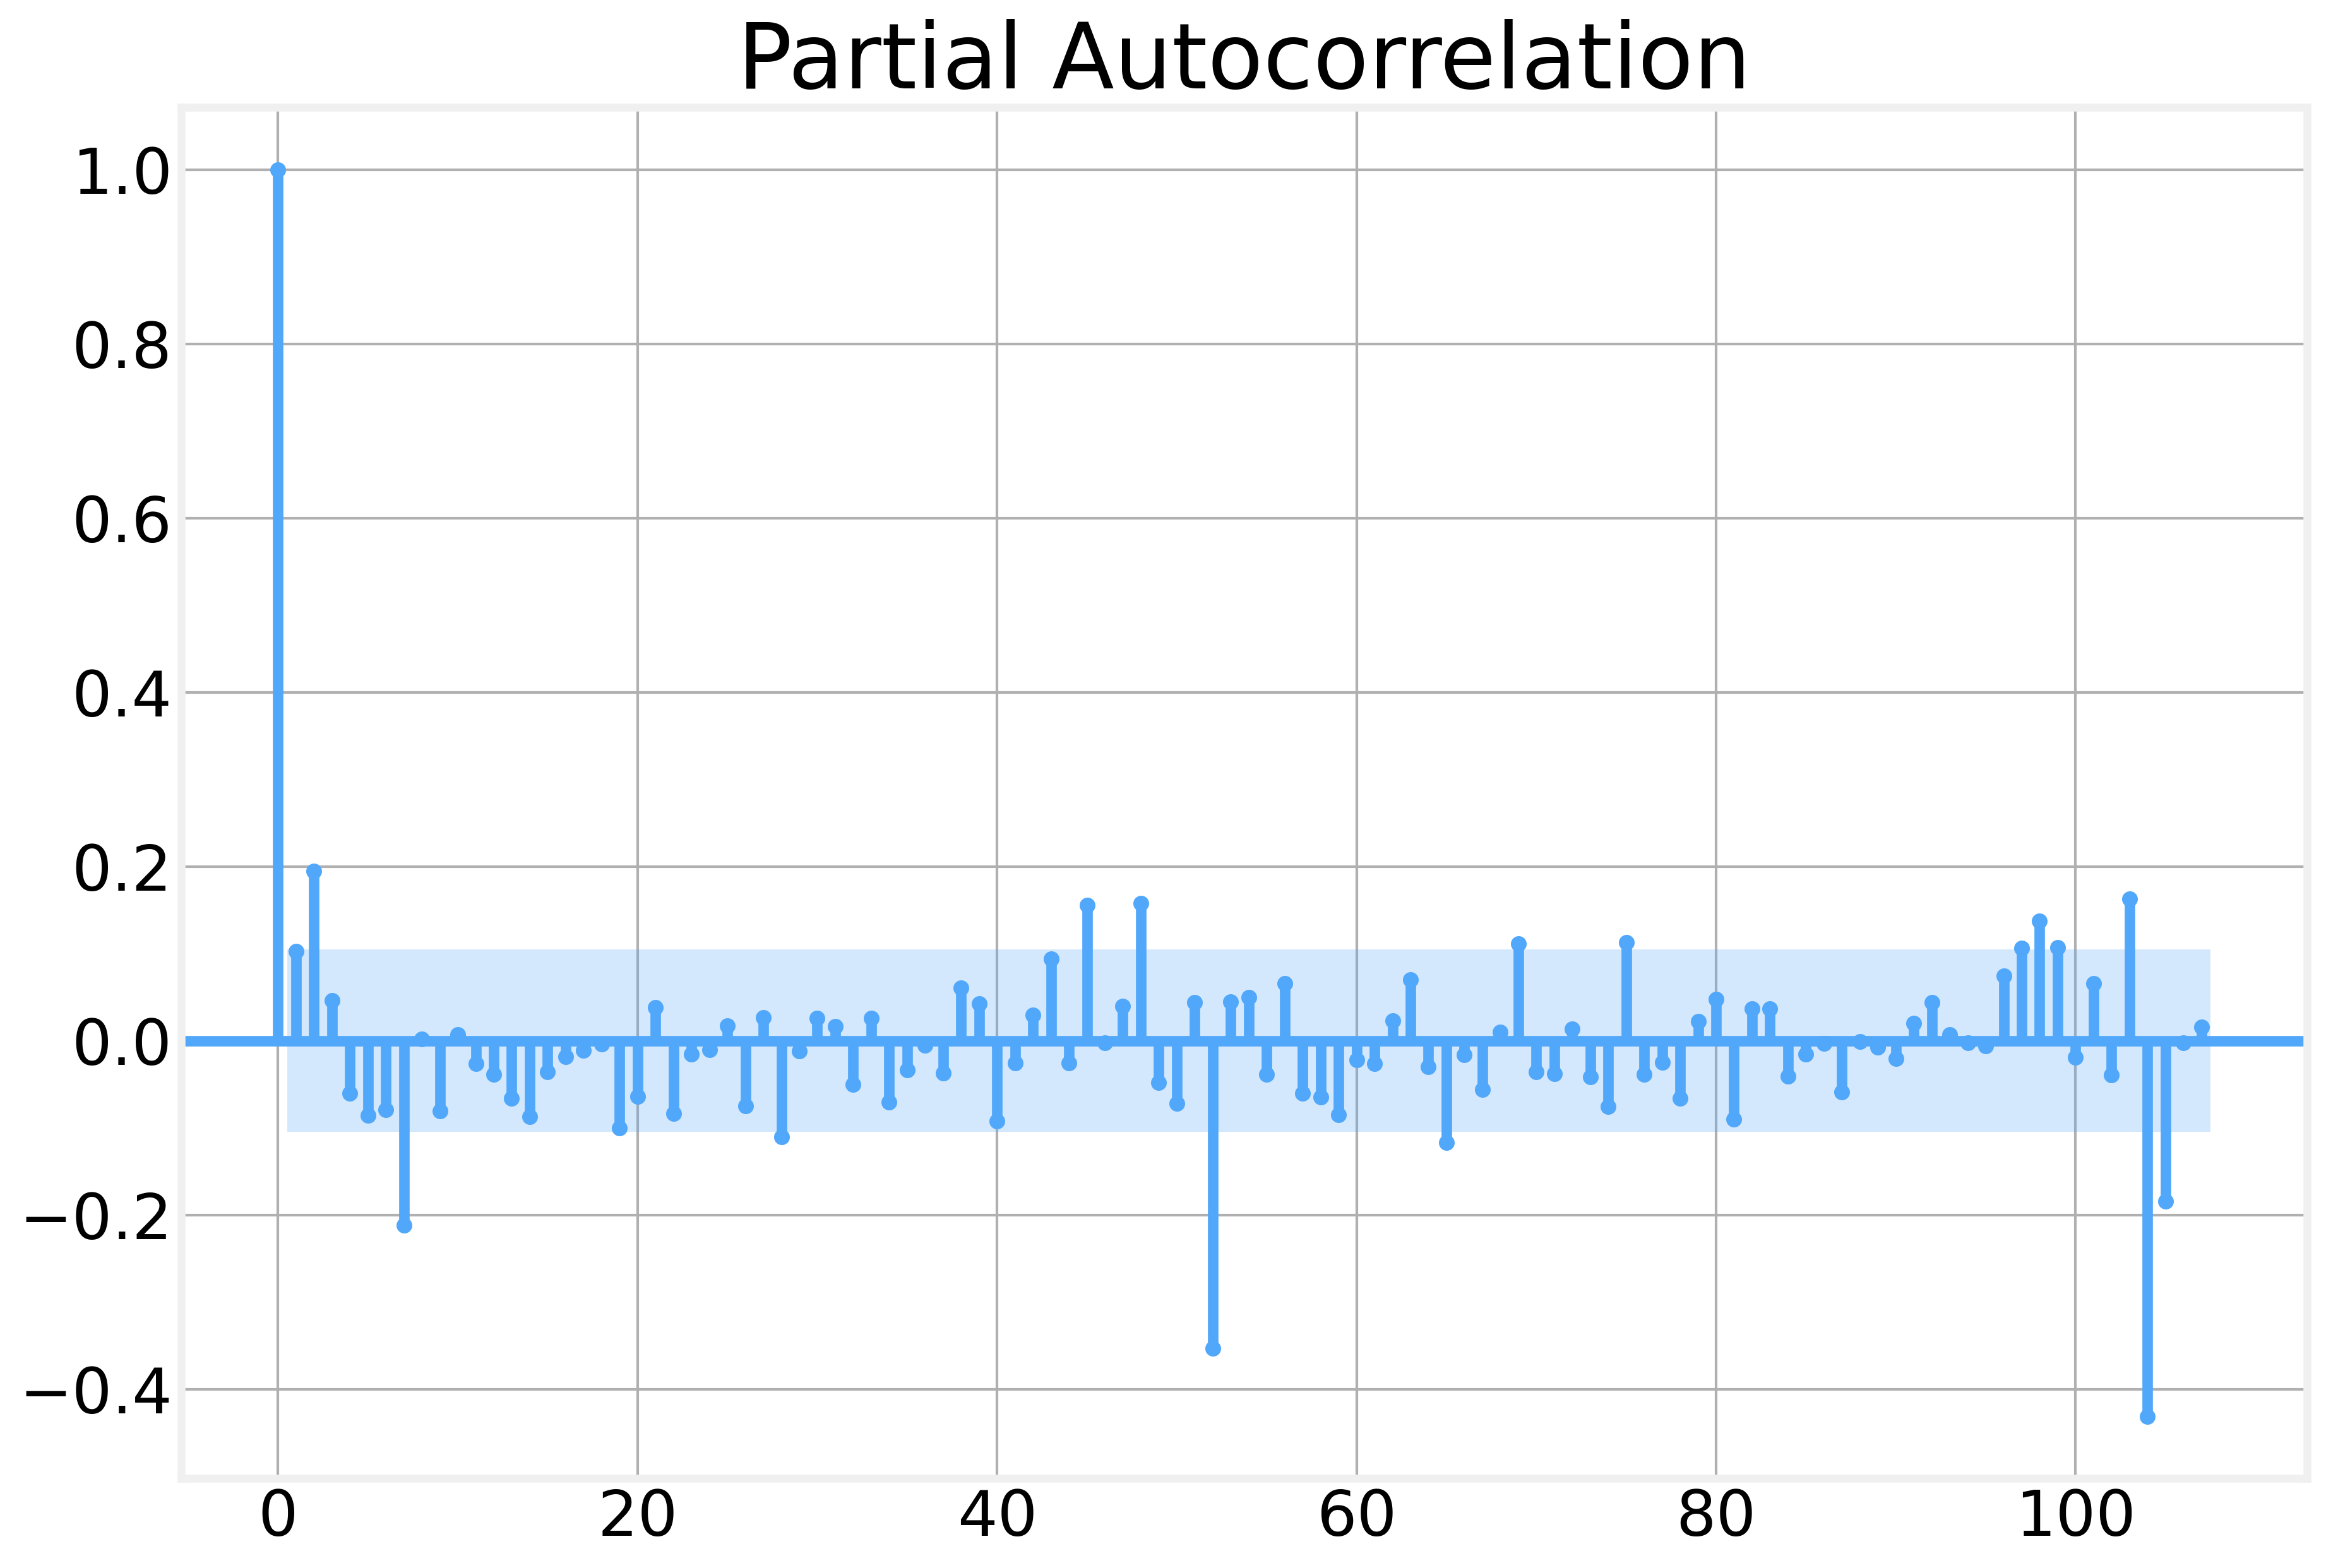

In [24]:
sm.graphics.tsa.plot_pacf(seasonal_ILI, lags=107);

In [25]:
mod = sm.tsa.statespace.SARIMAX(ILI.values,
                                order=(2, 1, 2),
                                seasonal_order=(1, 1, 1, 52),
                                simple_differencing=False)

In [26]:
res = mod.fit()

In [27]:
ILI.shape

(403, 1)

In [28]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  403
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood                   3.377
Date:                              Fri, 15 Oct 2021   AIC                              7.247
Time:                                      10:50:55   BIC                             34.252
Sample:                                           0   HQIC                            17.996
                                              - 403                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4387      0.141     10.189      0.000       1.162       1.715
ar.L2         -0.7703      0.119     -6.452      0.000      -1.004      -0.536
ma.L1         -1.3420      0.140     -9.617      0.000      -1.615      -1.068
ma.L2          0.7651      0.109      7.049      0.000       0.552       0.978
ar.S.L52       0.1716      0.094      1.827      0.068      -0.012       0.356
ma.S.L52      -0.9930      3.394     -0.293      0.770      -7.646       5.660
sigma2         0.0446      0.148      0.301      0.763      -0.246       0.335
===================================================================================
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                38.30
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.47
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

And we can visualize our extrapolation

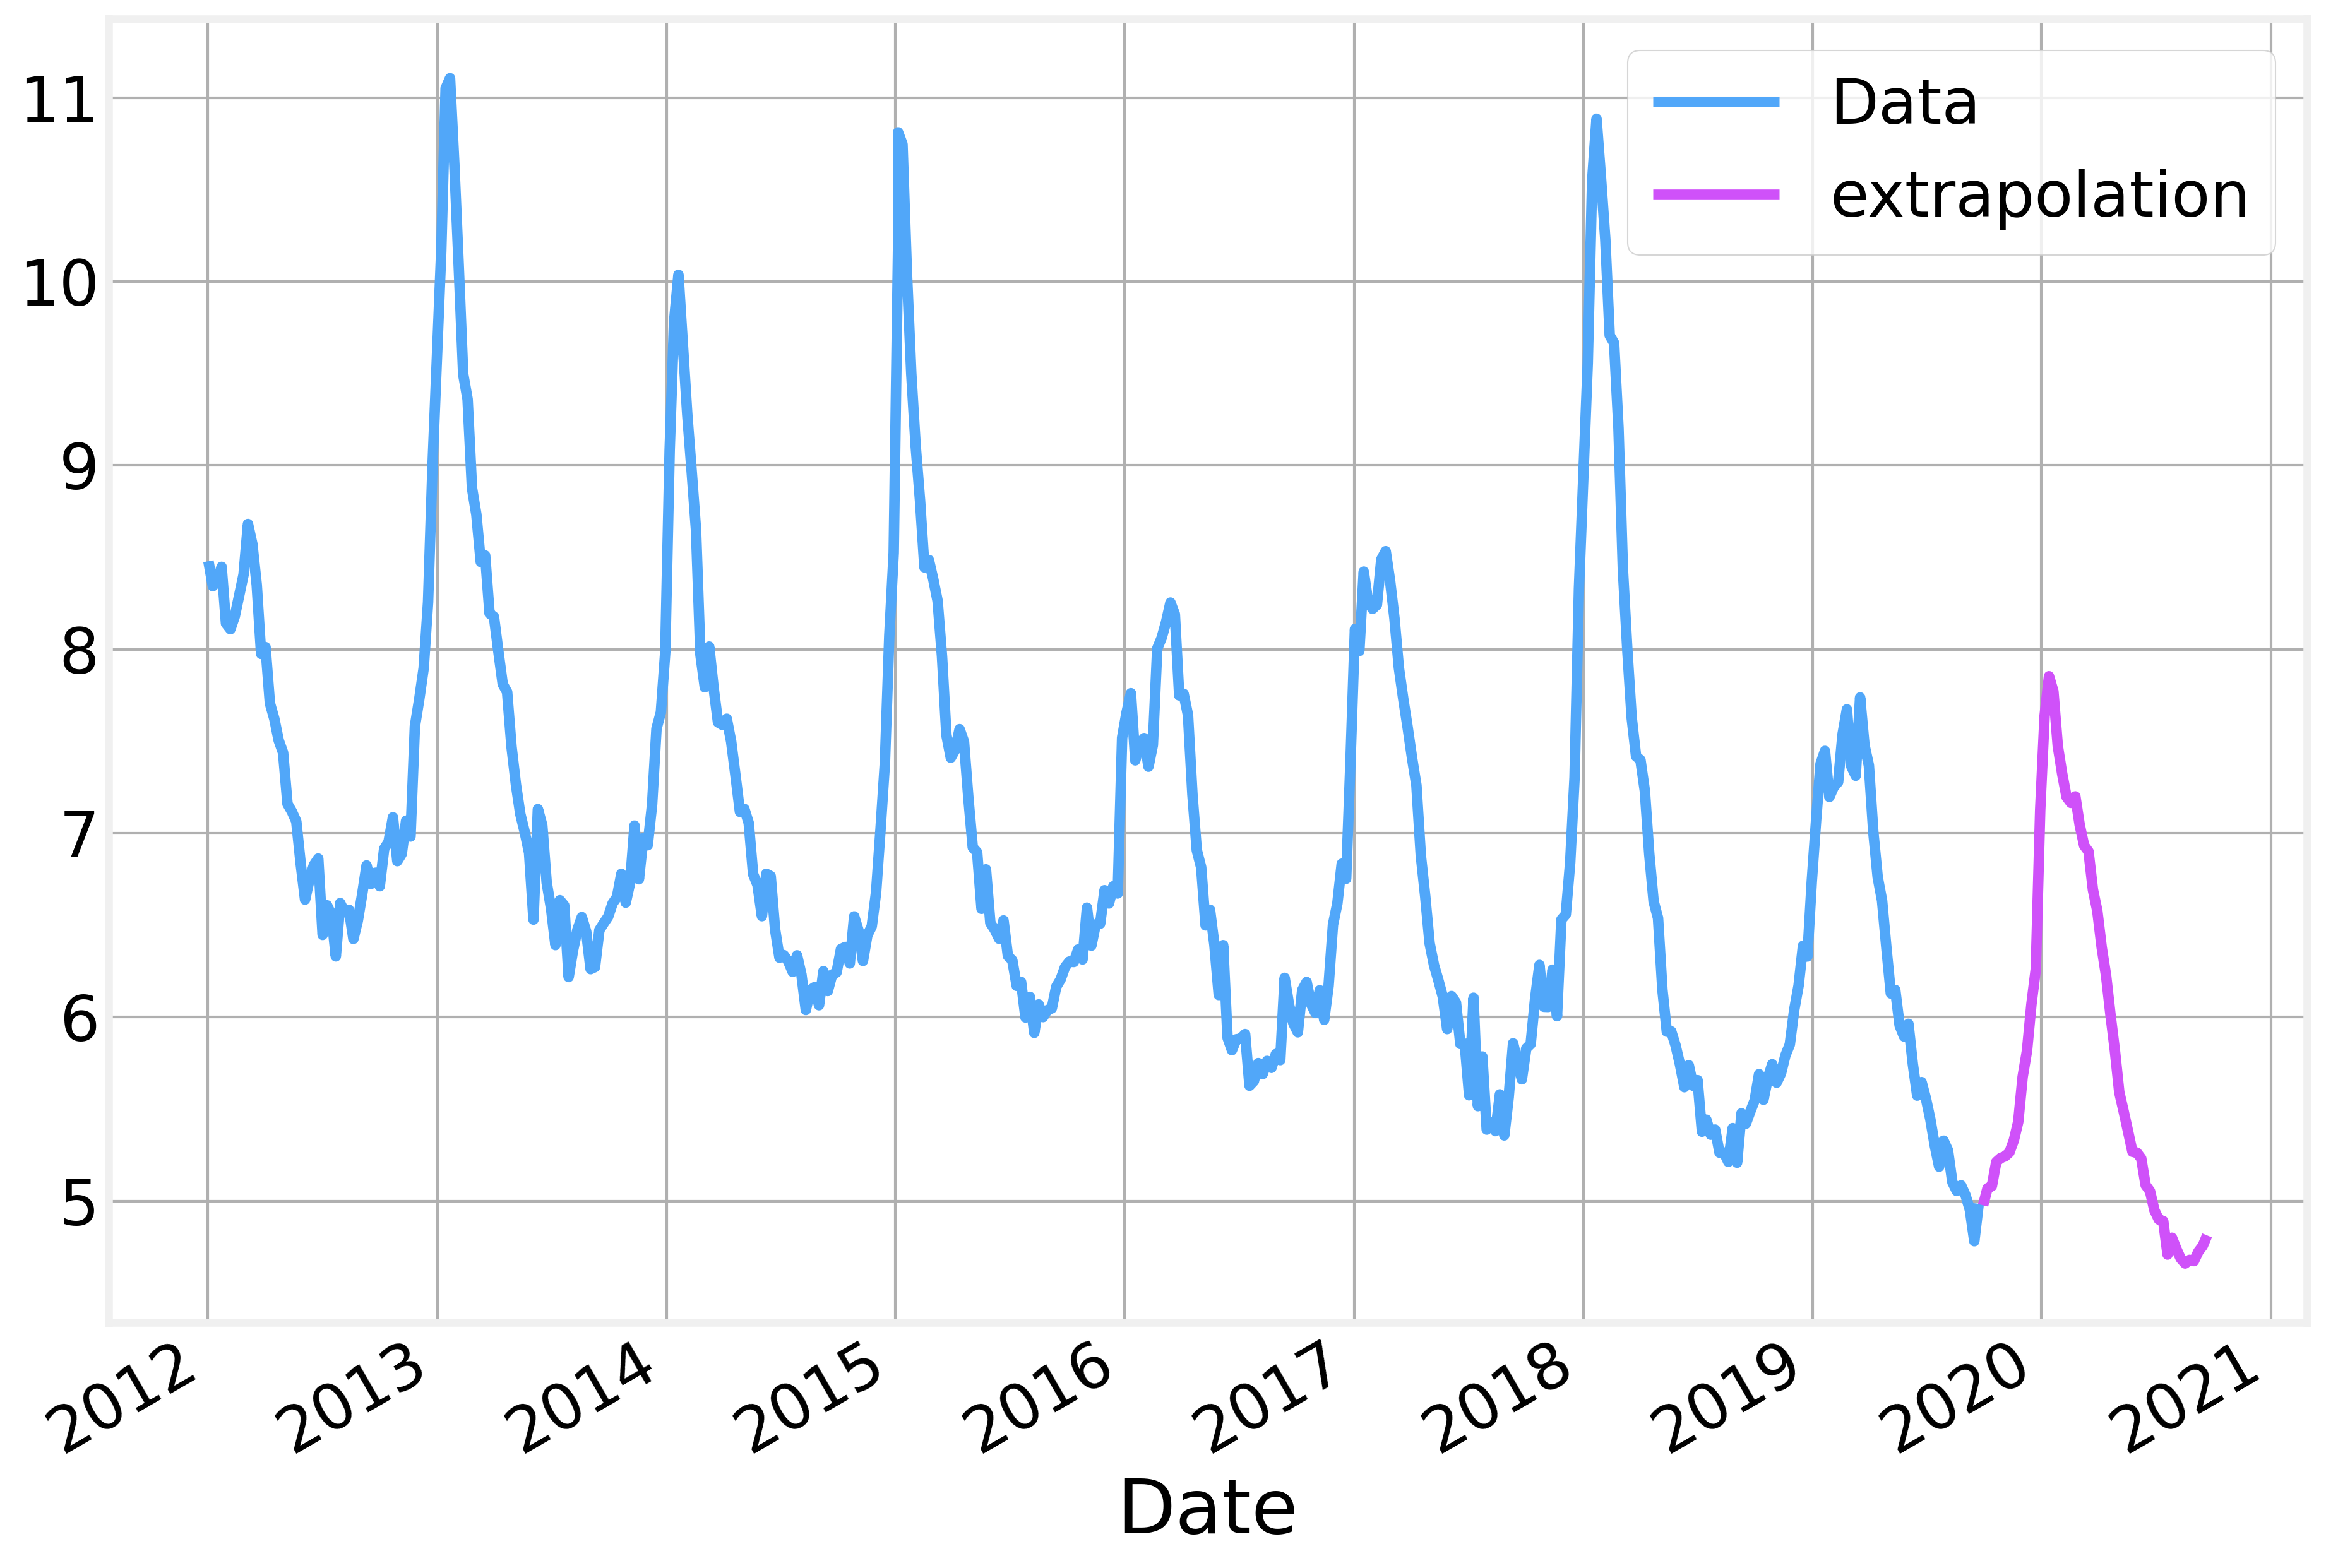

In [32]:
ax = ILI.plot()
forecast = res.forecast(52)
new_weeks = ILI.index[-1]+pd.timedelta_range('7 day', periods=52, freq='7d')
ax.plot(new_weeks, forecast)
ax.legend(['Data', 'extrapolation'])

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>